# The Human Disease Network

Álvaro Huertas García

Sara Dorado Alfaro

Enlaces:

* https://nbviewer.jupyter.org/github/empet/Human-Disease-Network/blob/master/Human-Disease-Network.ipynb

* http://snap.stanford.edu/deepnetbio-ismb/ipynb/Human+Disease+Network.html 

Algunos parámetros calculados requieren tener la última versión de `Network x`

In [2]:
! pip install --upgrade networkx
import networkx as nx
nx.__version__

'2.4'

## Load Graph

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import csv
import numpy as np
import pandas as pd
import glob
import matplotlib.image as mpimg
from scipy.optimize import curve_fit
%matplotlib inline
import collections

A continuación, importamos los datos correspondientes a los nodos (enfermedades) de la red Human Disease Network (HDN)

In [2]:
hdn = nx.read_edgelist('diseasome.edgelist.txt')
hdn.name = 'Human Disease Network'

# Comprobamos que los nodos carecen de informacion
hdn.nodes["222"]

{}

Cargamos el archivo con la meta-información para cada uno de los nodos. Se cargan como objetos `panda`. Observamos como tenemos 3 columnas: `Id`, `Label` y `Disease class`

In [3]:
### Load labels into
# metadata = pd.read_csv('disease.labels.txt', index_col='Id')
# metadata.index
metadata = pd.read_csv('disease.labels.txt')
metadata.head()

Id                                        Label Disease class
0  222                                 Osteoporosis          Bone
1  306                         Epiphyseal dysplasia          Bone
2  277                                Osteopetrosis          Bone
3  286                      Osteogenesis imperfecta          Bone
4  288  Achondrogenesis-hypochondrogenesis, type II          Bone

A continuación vamos a añadir a los nodos la meta-información. Para ello empleamos el atributo `add_node` de `networkx`. La columna `Label` pasará a ser la etiqueta `Disease` y la columna `Disease class` pasará a ser la etiqueta `Class`. De este modo, conseguimos incorporar información a los nodos de la red para facilitar la contextualización biológica cuando realicemos diferentes estudios sobre la misma. 

In [4]:
for node_id, data_label, data_class in zip(metadata["Id"], metadata["Label"], metadata["Disease class"]):
    hdn.add_node(str(node_id), Disease = data_label, Class = data_class)

# Prueba de que se ha añadido correctamente la informacion
hdn.nodes["55"]

{'Disease': 'Deafness', 'Class': 'Ear,Nose,Throat'}

In [5]:
nx.write_edgelist(hdn, path = "./hdn_nodes_label.csv", delimiter=' ', data=True, encoding='utf-8')
nx.write_gexf(hdn, path = "hdn_simple.gexf", encoding='utf-8', prettyprint=True, version='1.1draft')

In [6]:
pd.unique(metadata["Disease class"])

array(['Bone', 'Cancer', 'Cardiovascular', 'Connective tissue disorder',
       'Dermatological', 'Developmental', 'Ear,Nose,Throat', 'Endocrine',
       'Gastrointestinal', 'Hematological', 'Immunological', 'Metabolic',
       'Multiple', 'Muscular', 'Neurological', 'Nutritional',
       'Ophthamological', 'Psychiatric', 'Renal', 'Respiratory',
       'Skeletal', 'Unclassified'], dtype=object)

## Representación de la red

Paralelamente al análisis de la red, se llevará a cabo su visualizacion en Gephi y Cytoscape. Para ello es necesario filtrar la información de los archivos "gexf". Los archios de "gexf" de HDN contienen originalmente tanto las enfermedades como los genes alterados que las producen. De este modo, se extraen únicamente los nodos correspondientes a enfermedades y las aristas entre ellas. Se mantiene el tamaño del nodo en función del número de genes alterados asociadas a esa enfermedad. 

El efecto del filtrado se puede observar a continuación:

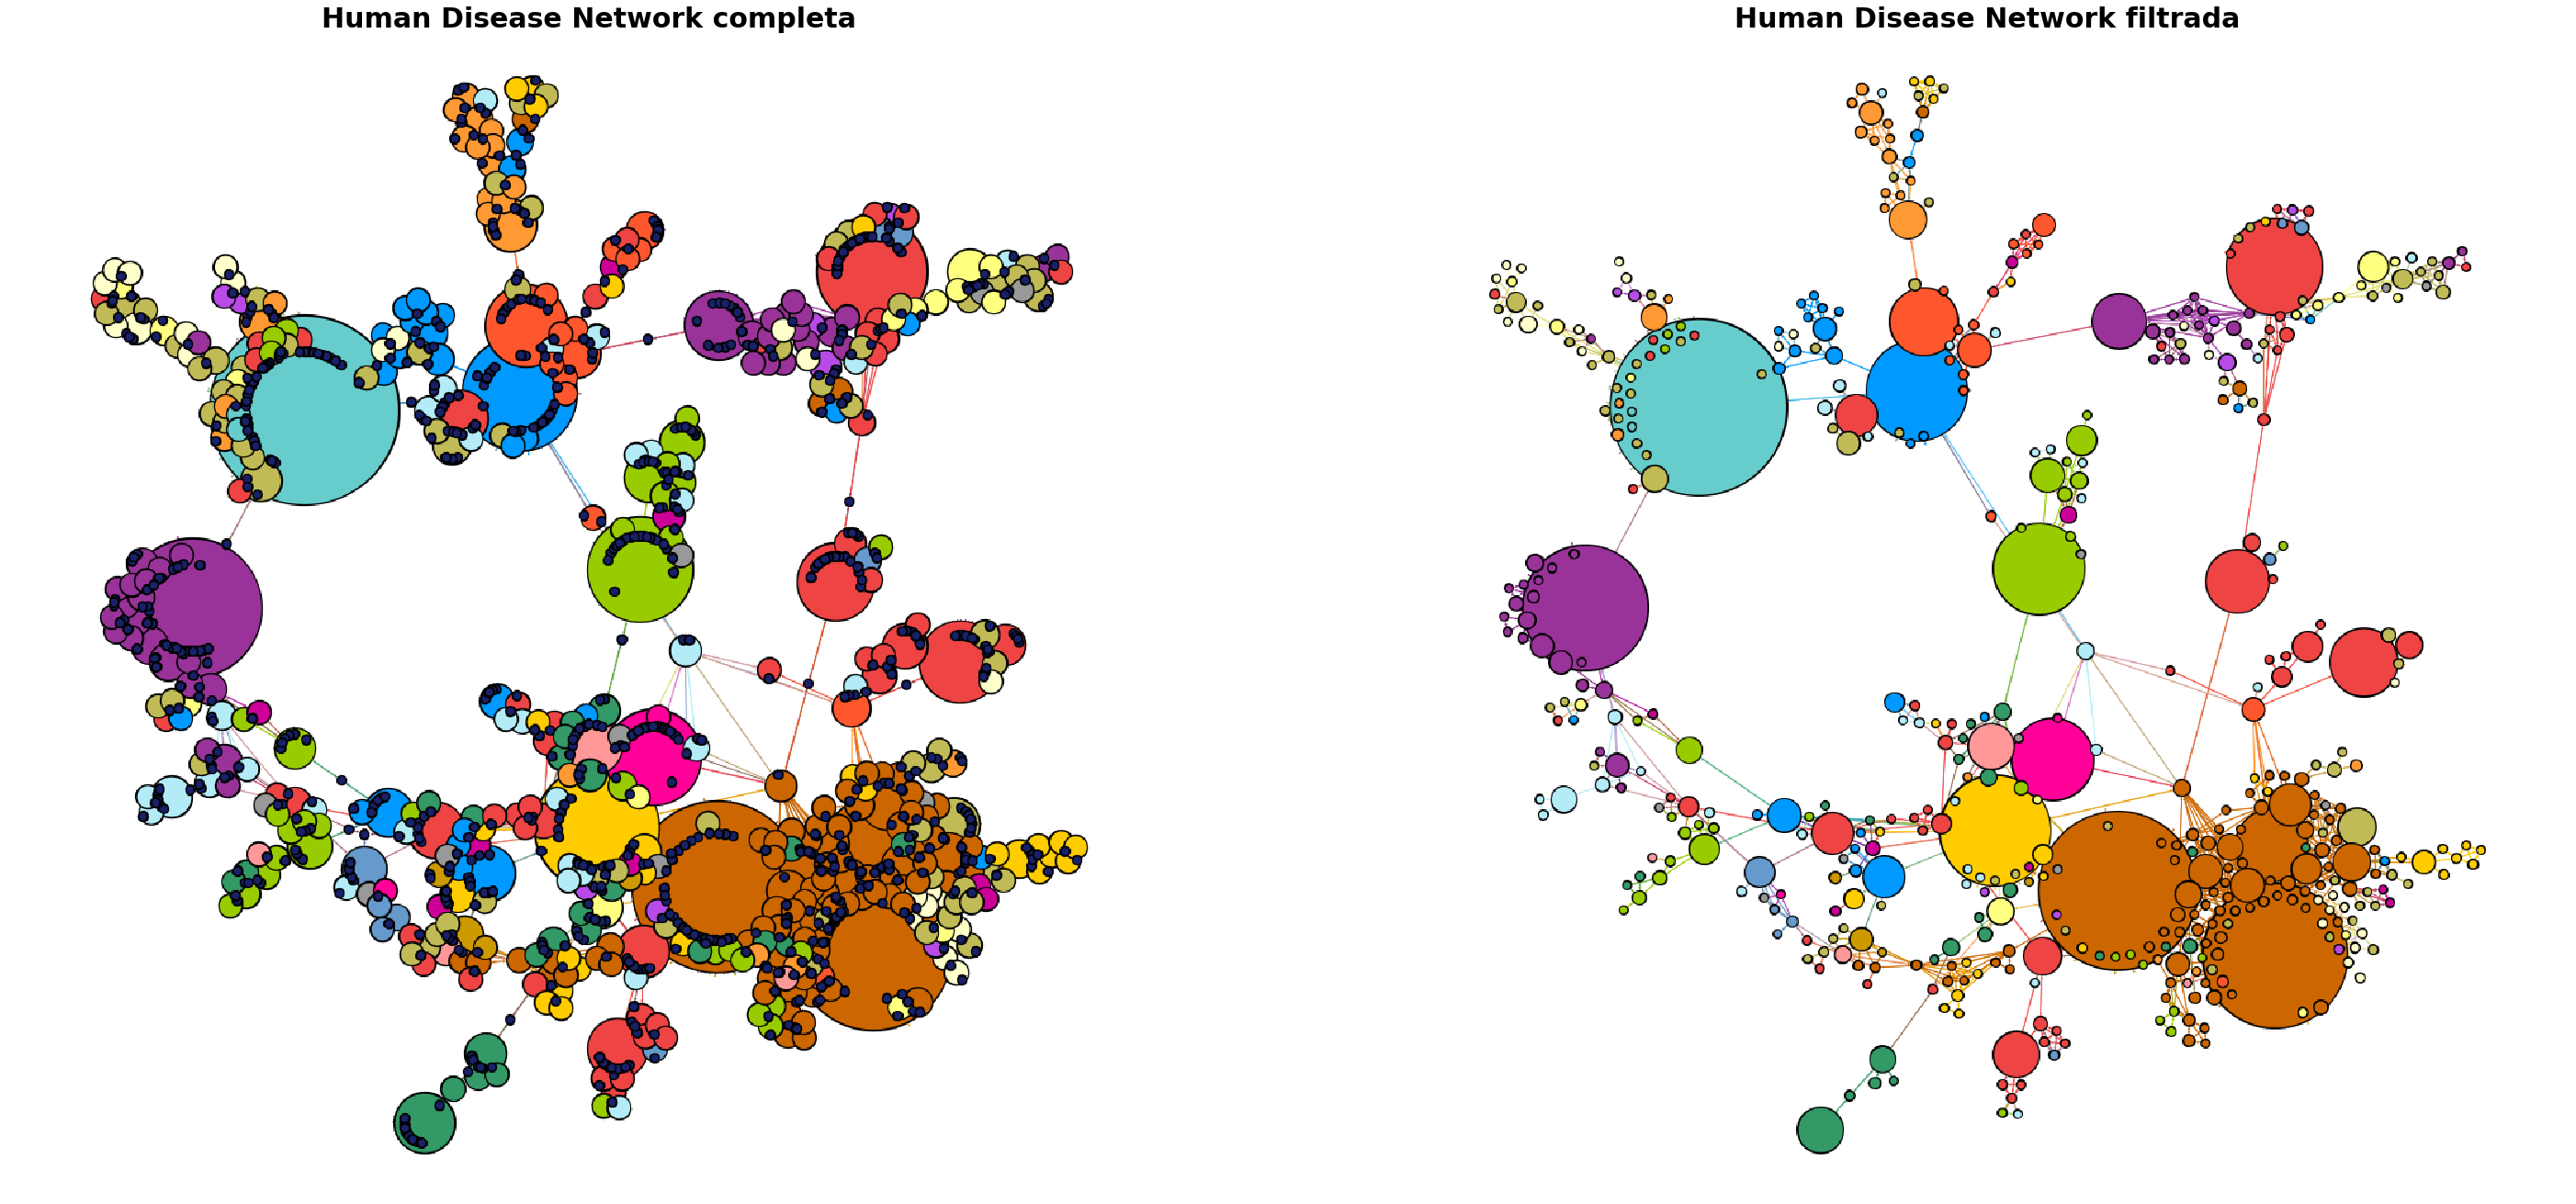

In [8]:
images = []
paths = []

# Seleccionamos los paths a las imagenes
for img_path in glob.glob('./Imagenes/Red/*.png'):
    paths.append(img_path)
    
# Ordenamos los archivos
paths.sort()    

# Cargamos las imagenes 
for image in paths:
    images.append(mpimg.imread(image))
    

# ax enables access to manipulate each of subplots
ax = []   
titles = ["Human Disease Network completa", "Human Disease Network filtrada"]
ar_p = np.array([0,0.0001,0.0003,0.0006, 0.001,0.003,0.006,0.01,0.03,0.06,0.1, 0.3,0.6,1.])
fig = plt.figure(figsize=(50,50))
rows = 1
columns = 2
for i, image in enumerate(images):
    ax.append( fig.add_subplot(rows , columns, i+1) )
    ax[-1].set_title(titles[i], fontsize = 30, fontweight = "bold")
    plt.imshow(image)
    plt.axis('off')

La red que se va a analizar es la  **"Human Disease Network filtrada"**. Nos interesa estudiar cómo se relacionan las diferentes enfermedades y, para ello, sólo existirán nodos correspondientes a las mismas y no los nodos correspondientes a genes. 

## Graph Analysis

En primer lugar, se procede a realizar un análisis exploratorio de la red. En esta red los nodos son enfermedades y se encuentran conectadas entre sí, si comparten algún gen cuya mutación desencadena el fenotipo patológico. 

Podemos comprobar que la red se compone de 516 enfermedades, con un total de 1188 conexiones entre sí. 

In [9]:
col_al = "palegreen"
col_hdn = "lightblue"

### Información general

In [75]:
## Orden y tamaño
tam =  nx.number_of_edges(hdn) # numero de aristas
orden = nx.number_of_nodes(hdn) # numero de vertices
print(nx.info(hdn))

Name: Human Disease Network
Type: Graph
Number of nodes: 516
Number of edges: 1188
Average degree:   4.6047


Comprobamos si se trata de un grafo dirigido o no dirigido. 

In [11]:
ave_degree = 4.6
print(nx.is_directed(hdn))

False


Procedemos a estudiar la densidad del grafo, con la función `density` de `networkx`. La densidad para un grafo no dirigido se define como:

$$d = \dfrac{2|E|}{N(N-1)}$$

siendo $|E|$ el número de vértices y $N$ el número de nodos que componen el grafo. Al ser muy cercano a 0 podemos asegurar que se trata de un grafo disperso. El hecho de se trate de un grafo disperso es bueno y lo hace interesante de estudiar.

### Densidad

In [12]:
densidad = nx.density(hdn)
print(densidad)

0.008941070219011063


### Conectividad

Veamos si se trata de un grafo conexo.

In [13]:
nx.is_connected(hdn)

True

### Distancias


Vamos a estudiar distintos parámetros de distancia en el grafo. Se va a estudiar el diámetro del grafo, la cercanía, la excentricidad y la intermediación. 

#### Excentricidad 
The maximum eccentricity is the graph diameter. The minimum graph eccentricity is called the graph radius

#### Radio (mínima excentricidad) y centro
The radius is the minimum eccentricity `radius(G, e=None`
The center is the set of nodes with eccentricity equal to radius. `center(G, e=None)`

#### Diámetro (máxima excentricidad) y periferia 
El **diámetro** del grafo es la distancia de grafo más larga entre dos nodos cualesquiera de la red (es decir, cómo de lejos están los 2 nodos más alejados). El diámetro, por tanto, corresponde al camino mínimo más largo. 

The periphery is the set of nodes with eccentricity equal to the diameter. `periphery(G, e=None, usebounds=False)`

In [14]:
# externalidad = nx.eccentricity(hdn)

print("Radio", nx.radius(hdn))
# print("Radio: ", min(externalidad.items(), key = lambda k: k[1]))  # ('736', 8)
centro = nx.center(hdn)
print("Nodos en el radio: ", centro, [hdn.nodes[i] for i in centro ])


print("\nDiámetro:", nx.diameter(hdn))
# print("Diametro: ", max(externalidad.items(), key = lambda k: k[1])) #  ('829', 15
periferia =  nx.periphery(hdn) 
print("Nodos de la periferia:", periferia, [hdn.nodes[i] for i in periferia])

Radio 8
Nodos en el radio:  ['736', '54', '426'] [{'Disease': 'Lipodystrophy', 'Class': 'Metabolic'}, {'Disease': 'Cardiomyopathy', 'Class': 'Cardiovascular'}, {'Disease': 'Emery-Dreifuss muscular dystrophy', 'Class': 'Muscular'}]

Diámetro: 15
Nodos de la periferia: ['829', '828', '962'] [{'Disease': 'Norrie disease', 'Class': 'Neurological'}, {'Disease': 'Coats disease', 'Class': 'Ophthamological'}, {'Disease': 'Rh-mod syndrome', 'Class': 'Hematological'}]


The barycenter is also called the median. Actuaría como un centroide del grafo. No tiene que ver con la conexión, sino con la posición del nodo.  

## Clustering

### Triángulos 

Número de triángulos que incluyen a un nodo. Interesante para encontrar nodos con muchos triángulos. 

### Transitividad del grafo

Possible triangles are identified by the number of “triads” (two edges with a shared vertex).

$$T = 3 \dfrac{triangulos}{triadas}$$

Es una forma de ver como de clusterizado está. 


### Índice de clusteriación

In [15]:
max_triang = max(nx.triangles(hdn).items(), key = lambda pareja: pareja[1])
print("Nodo con más triángulos", max_triang[1], hdn.nodes[max_triang[0]])
print("Transitividad del grafo", nx.transitivity(hdn))
print("Índice de clusterización medio del grafo", nx.average_clustering(hdn))

Nodo con más triángulos 152 {'Disease': 'Colon cancer', 'Class': 'Cancer'}
Transitividad del grafo 0.4304705634100021
Índice de clusterización medio del grafo 0.6358304997771199


## Nodos importantes

In [8]:
k_cores = nx.core_number(hdn)
intermediacion = nx.betweenness_centrality(hdn)
cercania = nx.closeness_centrality(hdn)
centralidad = nx.degree_centrality(hdn)
clusters = nx.clustering(hdn)
triangulos = nx.triangles(hdn)

In [9]:
def info(Id):
    print(hdn.nodes[Id])
    print("K-core:", k_cores[Id])
    print("Grado:", hdn.degree[Id])
    print("Betweenness:", intermediacion[Id])
    print("Cercanía:", cercania[Id])
    print("Centralidad de grado:", centralidad[Id])
    print("Índice de clusterización:", clusters[Id])
    print("Triángulos que posee; ", triangulos[Id])

### Baricentro

In [18]:
baricentro = nx.barycenter(hdn)
info(baricentro[0])

{'Disease': 'Lipodystrophy', 'Class': 'Metabolic'}
K-core: 4
Grado: 8
Betweenness: 0.4094890365351985
Cercanía: 0.25183374083129584
Centralidad de grado: 0.015533980582524271
Índice de clusterización: 0.2857142857142857
Triángulos que posee;  8


### Nodo con más cercanía

In [11]:
mayor = max(cercania.items(), key = lambda pareja: pareja[1] )
Id = mayor[0]
print(Id)
info(Id)

736
{'Disease': 'Lipodystrophy', 'Class': 'Metabolic'}
K-core: 4
Grado: 8
Betweenness: 0.4094890365351985
Cercanía: 0.25183374083129584
Centralidad de grado: 0.015533980582524271
Índice de clusterización: 0.2857142857142857
Triángulos que posee;  8


### Nodo con más centralidad de grado

In [12]:
mayor = max(centralidad.items(), key = lambda pareja: pareja[1] )
Id = mayor[0]
print(Id)
info(Id)

114
{'Disease': 'Colon cancer', 'Class': 'Cancer'}
K-core: 10
Grado: 50
Betweenness: 0.13317800506363323
Cercanía: 0.22777532065457762
Centralidad de grado: 0.0970873786407767
Índice de clusterización: 0.12408163265306123
Triángulos que posee;  152


### Nodo con más intermediación 

In [13]:
mayor = max(intermediacion.items(), key = lambda pareja: pareja[1] )
Id = mayor[0]
print(Id)
info(Id)

54
{'Disease': 'Cardiomyopathy', 'Class': 'Cardiovascular'}
K-core: 4
Grado: 15
Betweenness: 0.4693742788693075
Cercanía: 0.23430391264786168
Centralidad de grado: 0.029126213592233007
Índice de clusterización: 0.10476190476190476
Triángulos que posee;  11


### Nodo destacable del k core 10 --> Cancer de Colon

In [19]:
# Cancer de colon 114
Id = "114"
info(Id)

{'Disease': 'Colon cancer', 'Class': 'Cancer'}
K-core: 10
Grado: 50
Betweenness: 0.13317800506363323
Cercanía: 0.22777532065457762
Centralidad de grado: 0.0970873786407767
Índice de clusterización: 0.12408163265306123
Triángulos que posee;  152


### Nodo del k core 10 más cerca del k core 7 --> Pancreatic cancer

In [20]:
# 59
Id = "59"
info(Id)

{'Disease': 'Pancreatic cancer', 'Class': 'Cancer'}
K-core: 10
Grado: 23
Betweenness: 0.027696515723487563
Cercanía: 0.2051792828685259
Centralidad de grado: 0.04466019417475728
Índice de clusterización: 0.2924901185770751
Triángulos que posee;  74


### Nodo del k core 10 más cercano al k core 9 --> Hepatic adenoma

In [21]:
# 224
Id = "224"
info(Id)

{'Disease': 'Hepatic adenoma', 'Class': 'Cancer'}
K-core: 10
Grado: 16
Betweenness: 0.07606550349432697
Cercanía: 0.22469458987783594
Centralidad de grado: 0.031067961165048542
Índice de clusterización: 0.425
Triángulos que posee;  51


### Nodo del k core 9 más cercano al k core 10  y más cercano al k core 7--> Cataract

In [22]:
# 325
Id = "325"
info(Id)

{'Disease': 'Cataract', 'Class': 'Ophthamological'}
K-core: 9
Grado: 11
Betweenness: 0.16830493747875033
Cercanía: 0.17206815903775477
Centralidad de grado: 0.021359223300970873
Índice de clusterización: 0.6545454545454545
Triángulos que posee;  36


### Nodo del k core 7 más cercano al 10 y al 9 --> Lipoma

In [23]:
# 742
Id = "742"
info(Id)

{'Disease': 'Lipoma', 'Class': 'Cancer'}
K-core: 7
Grado: 10
Betweenness: 0.0414603634143885
Cercanía: 0.17746381805651276
Centralidad de grado: 0.019417475728155338
Índice de clusterización: 0.4888888888888889
Triángulos que posee;  22


## Page Rank [link](https://towardsdatascience.com/graph-algorithms-part-2-dce0b2734a1d) --> Colon Cancer

PageRank estimates a current node’s importance from its linked neighbors and then again from their respective neighbors.

Although popularized by Google, it’s a way of detecting influential nodes in any network. It is for example used to suggest connections on social networks.

PageRank is computed by either iteratively distributing one node’s rank (originally based on the degree) over its neighbors or by randomly traversing the graph and counting the frequency of hitting each node during these walks.

PageRank is usually computed on directed graphs. However, it will also execute on undirected graphs by converting each edge in the directed graph to two edges.

In [102]:
Id = max(nx.pagerank(hdn, alpha=0.9).items(), key = lambda k: k[1])[0]
info(Id)

{'Disease': 'Colon cancer', 'Class': 'Cancer'}
K-core: 10
Grado: 50
Betweenness: 0.13317800506363323
Cercanía: 0.22777532065457762
Centralidad de grado: 0.0970873786407767
Índice de clusterización: 0.12408163265306123
Triángulos que posee;  152


Buscamos ciclos

In [51]:
ciclos = nx.cycle_basis(hdn)
print(ciclos[1])

[hdn.node[i]for i in ciclos[1]]

['577', '574', '578']


[{'Disease': 'Osseous heteroplasia', 'Class': 'Bone'},
 {'Disease': 'Pituitary ACTH-secreting adenoma', 'Class': 'Cancer'},
 {'Disease': 'Pseudohypoparathyroidism', 'Class': 'Endocrine'}]

## Comparación con un grafo aleatorio

In [76]:
# Grafo aleatorio de mismo orden y tamaño
# Reutilizamos orden y tamaño calculado previamente

G_AL = nx.gnm_random_graph(orden, tam)
G_AL.name = "Aleatorio" # añadimos el atributo nombre

# Comprobamos que las caracteristicas sean iguales
print(nx.info(G_AL))

Name: Aleatorio
Type: Graph
Number of nodes: 516
Number of edges: 1188
Average degree:   4.6047


In [19]:
print("Aleatorio (G_AL) -->", nx.is_connected(G_AL),
      "\nNúmero de componentes (G_AL):", nx.number_connected_components(G_AL), 
      "\n\nGrafo inicial (hdn) --> ", nx.is_connected(hdn),
      "\nNúmero de componentes (hdn):", nx.number_connected_components(hdn))

Aleatorio (G_AL) --> False 
Número de componentes (G_AL): 2 

Grafo inicial (hdn) -->  True 
Número de componentes (hdn): 1


**Estudiamos la componente más grande (Networkx 2.4)**

Con `connected_components` sacas las componentes como lista de nodos. Con `subgraph` aplicado al grafo original y pasándole la lista de nodos extraes las componentes como subgrafos. Ya puedes aplicarle lo que uieras de networkx que ya sería un grafo

In [39]:
largest_cc = max(nx.connected_components(G_AL), key=len)
max_CC = G_AL.subgraph(largest_cc)
print(nx.info(max_CC))

Name: Aleatorio
Type: Graph
Number of nodes: 511
Number of edges: 1188
Average degree:   4.6497


The first returned value nr is the sum of non-randomness values of all edges within the graph (where the non-randomness of an edge tends to be small when the two nodes linked by that edge are from two different communities).

The second computed value nr_rd is a relative measure that indicates to what extent graph G is different from random graphs in terms of probability. When it is close to 0, the graph tends to be more likely generated by an Erdos Renyi model.

In [165]:
nx.non_randomness(hdn)

(186.3187863371036, -32.388568503923956)

El algoritmo requiere que el grafo sea conexo, y sobre la componente conexa más grade falla.

In [45]:
# Por alguna razón falla también sobre la componente conexa más grande.
# No es posible calcular 
try:
    print(nx.non_randomness(max_CC))
except:
    print("ValueError: math domain error")

ValueError: math domain error


## Parámetros $\sigma$ y $\omega$

A small world network is characterized by a small average shortest path length, and a large clustering coefficient.

Small-worldness is commonly measured with the coefficient sigma or omega.

Both coefficients compare the average clustering coefficient and shortest path length of a given graph against the same quantities for an equivalent random or lattice graph.

**Sigma** 
The small-world coefficient is defined as: 

$$\sigma =\dfrac{C / C_r}{L /L_r} $$ 

where C and L are respectively the average clustering coefficient and average shortest path length of G. Cr and Lr are respectively the average clustering coefficient and average shortest path length of an equivalent random graph.

A graph is commonly classified as small-world if sigma>1.

**Omega** 

The small-world coefficient of a graph G is:

$$\omega = \dfrac{L_r}{L} - \dfrac{C}{C_l}$$ 

where C and L are respectively the average clustering coefficient and average shortest path length of G. Lr is the average shortest path length of an equivalent random graph and $C_l$ is the average clustering coefficient of an equivalent lattice graph.

The small-world coefficient (omega) ranges between -1 and 1. Values close to 0 means the G features small-world characteristics. Values close to -1 means G has a lattice shape whereas values close to 1 means G is a random graph.

### Human Disease Network

In [34]:
# Human Disease Network
nx.sigma(hdn, niter = 10, nrand = 3)

10.058497643802738

In [ ]:
# Human Disease Network
nx.sigma(hdn)

In [35]:
# Human Disease Network
nx.omega(hdn)

-0.7194237817688811

### Grafo aleatorio

In [40]:
# Componente gigante de grafo aleatorio
nx.sigma(max_CC, niter = 10, nrand = 3)

1.674300926633277

In [42]:
# Componente gigante grafo aleatorio
nx.sigma(max_CC)

In [41]:
# Componente gigante de grafo aleatorio
nx.omega(max_CC, niter = 10, nrand = 3)

0.80080246494917

In [ ]:
# Componente gigante grafo aleatorio
nx.omega(max_CC)

### Comparación de parámetros con 20 grafos aleatorios

Con el fin de realizar comparaciones justas. Esto se hace para tener valores robustos de parámetros como el camino característico o el coeficiente de clusterización. Después se comprobará si los valores obtenidos para el grafo CaernoElegans y grafos aleatorios con el mismo orden y tamaño son distintos de manera significativa, teniendo en cuenta la media y la desviación estándar.

In [ ]:
for i in range(0, 1):
    g = nx.gnm_random_graph(orden, tam, seed=i)
    max_cc_g = g.subgraph(max(nx.connected_components(g), key=len))
    
    # Densidad
    l_densidad.append(nx.density(g))
    
    # Radio
    try:
        l_radio.append(nx.radius(g))
    except: 
        l_radio.append(nx.radius(max_cc_g))
    
    # Diametro
    try:
        l_diametro.append(nx.diameter(g))
    except:
        l_diametro.append(nx.diameter(max_cc_g))
        
    # Transitividad
    l_transitividad.append(nx.transitivity(g))
    
    # Triángulos
    l_max_tri.append(max(nx.triangles(g).items(), key = lambda pareja: pareja[1])[1])    

In [94]:
l_densidad = []
l_radio = []
l_diametro = []
l_transitividad = []
l_max_tri = []
for i in range(0, 1):
    g = nx.gnm_random_graph(orden, tam, seed=i)
    max_cc_g = g.subgraph(max(nx.connected_components(g), key=len))
    print(nx.number_connected_components(g))

7


In [96]:
# REPETIMOS LOS CÁLCULOS PARA 20 GRAFOS ALEATORIOS

# Creamos las listas contenedoras de los resultados de diferentes iteraciones
l_densidad = []
l_centralidad = []
l_cercania = []
l_nodo_max_centralidad = []
l_nodo_max_cercania = []
l_betweenness = []
l_nodo_max_bt = []
l_clustering = []
l_nodo_max_clust = []
l_kcores = []
l_min_path = []
l_num_comp = []
l_diametro = []
l_densidad = []
l_radio = []
l_transitividad = []
l_max_tri = []

# Generamos un bucle para poder hacer métricas estadísticas de los parámetros del grafo aleatorio
for i in range(0, 20):
    g = nx.gnm_random_graph(orden, tam, seed=i) # Grafo que puede no ser conexo
    max_cc_g = g.subgraph(max(nx.connected_components( g ), key=len)) # Componente conexa más grande
    
    # Numero de componente y diametro de la componente gigante
    l_num_comp.append(nx.number_connected_components( g ))
    
    # Densidad
    l_densidad.append(nx.density( g ))
    
    # Radio
    try:
        l_radio.append(nx.radius( g ))
    except: 
        l_radio.append(nx.radius( max_cc_g ))
    
    # Diametro
    try:
        l_diametro.append(nx.diameter( g ))
    except:
        l_diametro.append(nx.diameter( max_cc_g ))
        
    # Transitividad
    l_transitividad.append(nx.transitivity( g ))
    
    # Triángulos
    l_max_tri.append(max(nx.triangles( g ).items(), key = lambda pareja: pareja[ 1 ])[ 1 ])
    
    
    # Centralidad
    l_centralidad.append(sum(nx.degree_centrality( g ).values()) /orden)
    l_nodo_max_centralidad.append(max(nx.degree_centrality( g ).items(), key = lambda pareja: pareja[ 1 ])[ 1 ])
    
    # Cercanía
    l_cercania.append(sum(nx.closeness_centrality( g ).values()) / orden)
    l_nodo_max_cercania.append(max(nx.closeness_centrality( g ).items(), key = lambda pareja: pareja[ 1 ])[ 1 ])

    # Betweenness
    l_betweenness.append(sum(nx.betweenness_centrality( g ).values()) / orden)
    l_nodo_max_bt.append(max(nx.betweenness_centrality( g ).items(), key = lambda pareja: pareja[ 1 ])[ 1 ])

    # Indice de clusterizacion
    l_clustering.append(nx.average_clustering( g ))
    l_nodo_max_clust.append(max(nx.clustering( g ).items(), key = lambda pareja: pareja[ 1 ])[ 1 ])

    # max k-core
    l_kcores.append(max(nx.core_number( g ).values()))

    # Camino caracteristico
    try: 
        l_min_path.append(nx.average_shortest_path_length( g ))
    except:
        l_min_path.append(nx.average_shortest_path_length( max_cc_g ))

    

    
    
# Guardamos los resultados de la media y des. std en un diccionario para acceder posteriormente
dic_params = {}


# Numero de componente y diametro de la componente gigante
dic_params["Componentes"] = np.mean(np.array(l_num_comp)), np.std(np.array(l_num_comp))
dic_params["Diámetro"] = np.mean(np.array(l_diametro)), np.std(np.array(l_diametro))

# Densidad
dic_params["Densidad"] = np.mean(np.array(l_densidad)), np.std(np.array(l_densidad))

# Radio
dic_params["Radio"] = np.mean(np.array(l_radio)), np.std(np.array(l_radio))

# Transitividad
dic_params["Transitividad"] = np.mean(np.array(l_transitividad)), np.std(np.array(l_transitividad))

# Triangulos
dic_params["Triangulos"] = np.mean(np.array(l_max_tri)), np.std(np.array(l_max_tri))

# Centralidad
dic_params["Degree Centrality"] = np.mean(np.array(l_centralidad)), np.std(np.array(l_centralidad))
dic_params["Nodo max Degree Centrality"] = np.mean(np.array(l_nodo_max_centralidad)), np.std(np.array(l_nodo_max_centralidad))

# Cercanía
dic_params["Cercania"] = np.mean(np.array(l_cercania)), np.std(np.array(l_cercania))
dic_params["Nodo max cercania"] = np.mean(np.array(l_nodo_max_cercania)), np.std(np.array(l_nodo_max_cercania))

# Betweenness
dic_params["Betweenness"] = np.mean(np.array(l_betweenness)), np.std(np.array(l_betweenness))
dic_params["Nodo max betweenness"] = np.mean(np.array(l_nodo_max_bt)), np.std(np.array(l_nodo_max_bt))

# Indice de clusterizacion
dic_params["Clustering"] = np.mean(np.array(l_clustering)), np.std(np.array(l_clustering))
dic_params["Nodo max clustering"] = np.mean(np.array(l_nodo_max_clust)), np.std(np.array(l_nodo_max_clust))

# max k-core
dic_params["Max k-core"] = np.mean(np.array(l_kcores)), np.std(np.array(l_kcores))

# Camino caracteristico
dic_params["Shortest path"] = np.mean(np.array(l_min_path)), np.std(np.array(l_min_path))



# Visualizamos los resultados de los parámetros. 
print(dic_params)

{'Componentes': (6.25, 2.2332711434127295), 'Diámetro': (8.6, 0.5830951894845301), 'Densidad': (0.008941070219011062, 1.734723475976807e-18), 'Radio': (5.65, 0.47696960070847283), 'Transitividad': (0.008495408465928838, 0.0023098409038739254), 'Triangulos': (2.2, 0.5099019513592785), 'Degree Centrality': (0.008941070219011074, 5.0872078419997235e-18), 'Nodo max Degree Centrality': (0.023786407766990293, 0.0022872269882310186), 'Cercania': (0.2331843090794954, 0.001629194718003849), 'Nodo max cercania': (0.28637180636318854, 0.005544787313077212), 'Betweenness': (0.00616261425769725, 9.688543651745717e-05), 'Nodo max betweenness': (0.034411561589434134, 0.004877471343798548), 'Clustering': (0.007613115243929196, 0.0027938512134659736), 'Nodo max clustering': (0.475, 0.3085584763595603), 'Max k-core': (3.0, 0.0), 'Shortest path': (4.234149870220155, 0.026885491428501565)}


### Centralidad de grado

In [160]:
# Grafo inicial
dic_centralidad = nx.degree_centrality(hdn) # centralidad calculada para todos los nodos
# print (dic_centralidad)
# Promedio
promedio_centralidad = (sum(dic_centralidad.values()) / orden)

print("Centralidad media en la Human Disease Network: ", promedio_centralidad)

# Nodo con mayor valor de centralidad de grado
mayor = max(dic_centralidad.items(), key = lambda pareja: pareja[1] )
print("Nodo con mayor centralidad de grado: %s, (%s)"
      %(hdn.node[mayor[0]], mayor[1]))

Centralidad media en la Human Disease Network:  0.008941070219011102
Nodo con mayor centralidad de grado en la red de proteínas de C. elegans: {'Disease': 'Colon cancer', 'Class': 'Cancer'}, (0.0970873786407767)


In [172]:
print("Promedio de la centralidad media de grado en el grafo aleatorio: %s con %s desviación estándar"
      %(dic_params["Degree Centrality"][0], dic_params["Degree Centrality"][1]))

print()
print("Centralidad media del nodo con mayor centralidad de grado en el grafo aleatorio: %s, con desviación estándar %s" 
      %(dic_params["Nodo max Degree Centrality"][0], dic_params["Nodo max Degree Centrality"][1]))


Promedio de la centralidad media de grado en el grafo aleatorio: 0.008941070219011074 con 5.0872078419997235e-18 desviación estándar

Centralidad media del nodo con mayor centralidad de grado en el grafo aleatorio: 0.023786407766990293, con desviación estándar 0.0022872269882310186


La **cercanía** corresponde a la distancia media desde un nodo inicial a todos los demás nodos de la red. 


La **excentricidad** es la distancia desde un nodo al nodo más alejado de él en la red. 

La **intermediación** ("betweenness") mide la frecuencia con la que un nodo aparece en el camino más corto entre nodos de la red. 

### Cercanía

In [173]:
# Grafo inicial
dic_cercania = nx.closeness_centrality(hdn)
promedio_cercania = (sum(dic_cercania.values()) / orden)
print("Cercanía en HDN: ", promedio_cercania)
print()
mayor = max(dic_cercania.items(), key = lambda pareja: pareja[1] )
print("Nodo con mayor cercanía: %s, (%s)"
      %(hdn.node[mayor[0]], mayor[1]))

Cercanía en HDN:  0.15937101043257754

Nodo con mayor centralidad de grado en la red de proteínas de C. elegans: {'Disease': 'Lipodystrophy', 'Class': 'Metabolic'}, (0.25183374083129584)


In [174]:
print("Promedio de la cercanía media de grado en el grafo aleatorio: %s, con %s desviación estándar"
      %(dic_params["Cercania"][0], dic_params["Cercania"][1]))
print()
print("Centralidad media del nodo con mayor cercanía en el grafo aleatorio: %s, con desviación estándar %s" 
      %(dic_params["Nodo max cercania"][0], dic_params["Nodo max cercania"][1]))

Promedio de la cercanía media de grado en el grafo aleatorio: 0.2331843090794954, con 0.001629194718003849 desviación estándar

Centralidad media del nodo con mayor cercanía en el grafo aleatorio: 0.28637180636318854, con desviación estándar 0.005544787313077212


### Intermediación

In [169]:
# Grafo inicial
dic_bet = nx.betweenness_centrality(hdn)
promedio_bet = (sum(dic_bet.values()) / orden)
print("Beteewness en la red de proteínas de C. elegans: ", promedio_bet)

mayor = max(dic_bet.items(), key = lambda pareja: pareja[1] )
print("Nodo con mayor betweeness en la red de proteínas de C. elegans: %s, (%s)" 
      %(hdn.node[mayor[0]], mayor[1]))


Beteewness en la red de proteínas de C. elegans:  0.010717886679557774
Nodo con mayor betweeness en la red de proteínas de C. elegans: {'Disease': 'Cardiomyopathy', 'Class': 'Cardiovascular'}, (0.4693742788693075)


In [175]:
print("Promedio del betweenness medioo en el grafo aleatorio: %s, con %s desviación estándar"
      %(dic_params["Betweenness"][0], dic_params["Betweenness"][1]))
print()
print("Centralidad media del nodo con mayor betweenness en el grafo aleatorio: %s, con desviación estándar %s" 
      %(dic_params["Nodo max betweenness"][0], dic_params["Nodo max betweenness"][1]))

Promedio del betweenness medioo en el grafo aleatorio: 0.00616261425769725, con 9.688543651745717e-05 desviación estándar

Centralidad media del nodo con mayor betweenness en el grafo aleatorio: 0.034411561589434134, con desviación estándar 0.004877471343798548


### Camino caracteristico

In [178]:
# Grafo inicial
c = nx.average_clustering(hdn)
print("Índice de clusterización de la red de proteínas de C. elegans:", c)
mayor = max(nx.clustering(hdn).items(), key = lambda pareja: pareja[1])
print("El nodo con mayor índice de clusterización es: %s, (%s)" 
      %(hdn.node[mayor[0]], mayor[1]))

try:
    L = nx.average_shortest_path_length(hdn)
    print("Camino mínimo de la red de proteínas de C. elegans:", L)
except:
    print ("\nNo puede calcularse el camíno mínimo de un grafo no conexo")

Índice de clusterización de la red de proteínas de C. elegans: 0.6358304997771199
El nodo con mayor índice de clusterización es: {'Disease': 'Morning glory disc anomaly', 'Class': 'Skeletal'}, (1.0)
Camino mínimo de la red de proteínas de C. elegans: 6.5089937532926925


**Todas las enfermedades con un índice de lcusterización 1**

In [236]:
ordenado = sorted(nx.clustering(hdn).items(), key = lambda pareja: pareja[1], reverse = True)
enfermedades_c = [hdn.node[i[0]] for i in ordenado if i[1] == 1]
enfermedades_c

[{'Disease': 'Morning glory disc anomaly', 'Class': 'Skeletal'},
 {'Disease': 'Optic nerve hypoplasia/aplasia', 'Class': 'Ophthamological'},
 {'Disease': 'Keratitis', 'Class': 'Ophthamological'},
 {'Disease': 'Eye anomalies', 'Class': 'Ophthamological'},
 {'Disease': 'Foveal hypoplasia', 'Class': 'Ophthamological'},
 {'Disease': 'Aniridia, type II', 'Class': 'Ophthamological'},
 {'Disease': 'Weissenbacher-Zweymuller syndrome',
  'Class': 'Connective tissue disorder'},
 {'Disease': 'OSMED syndrome', 'Class': 'Bone'},
 {'Disease': 'Kniest dysplasia', 'Class': 'Skeletal'},
 {'Disease': 'Achondrogenesis-hypochondrogenesis, type II', 'Class': 'Bone'},
 {'Disease': 'SMED Strudwick type', 'Class': 'Skeletal'},
 {'Disease': 'Wagner syndrome', 'Class': 'Ophthamological'},
 {'Disease': 'Myotonia congenita', 'Class': 'Muscular'},
 {'Disease': 'Paramyotonia congenita', 'Class': 'Muscular'},
 {'Disease': 'Hyperkalemic periodic paralysis', 'Class': 'Neurological'},
 {'Disease': 'Cramps, potassium-ag

### Plot distribución del índice de clusterización

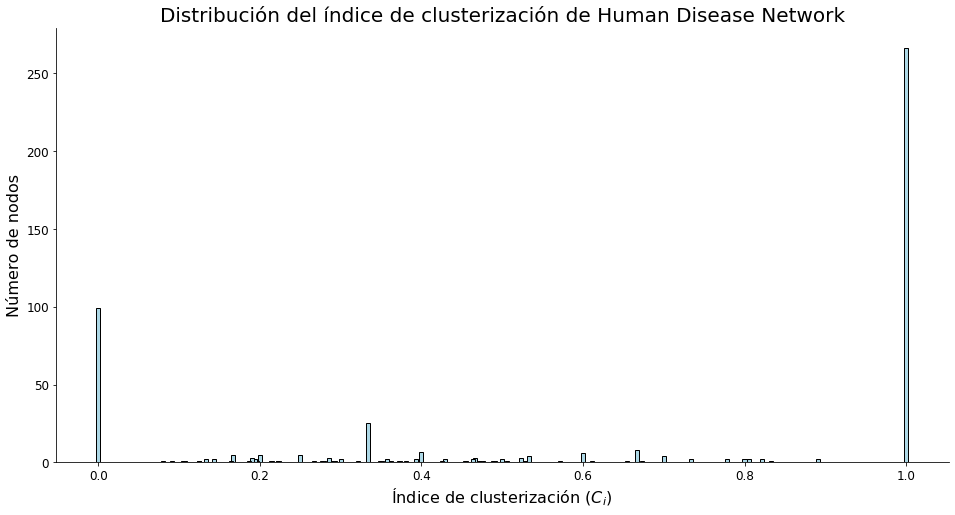

In [62]:
import collections
# Extraemos y ordenamos los valores de índice de clusterizacion
ordenado = sorted(nx.clustering(hdn).items(), key = lambda pareja: pareja[1], reverse = True)
valores_c = [i[1] for i in ordenado]

freq_c = collections.Counter(valores_c)



plt.figure(figsize = (16, 8))
plt.bar(freq_c.keys(), freq_c.values(), color= col_hdn, width = 0.005, edgecolor = "black", align = 'center')

# spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# titulo
plt.title("Distribución del índice de clusterización de Human Disease Network", fontsize = 20)

# ejes X y Y
plt.ylabel("Número de nodos", fontsize = 16)
plt.xlabel(r"Índice de clusterización ($C_i$)", fontsize = 16)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)





plt.savefig("./Imagenes/dist_clusterin_hdn.png", bbox_inches='tight')

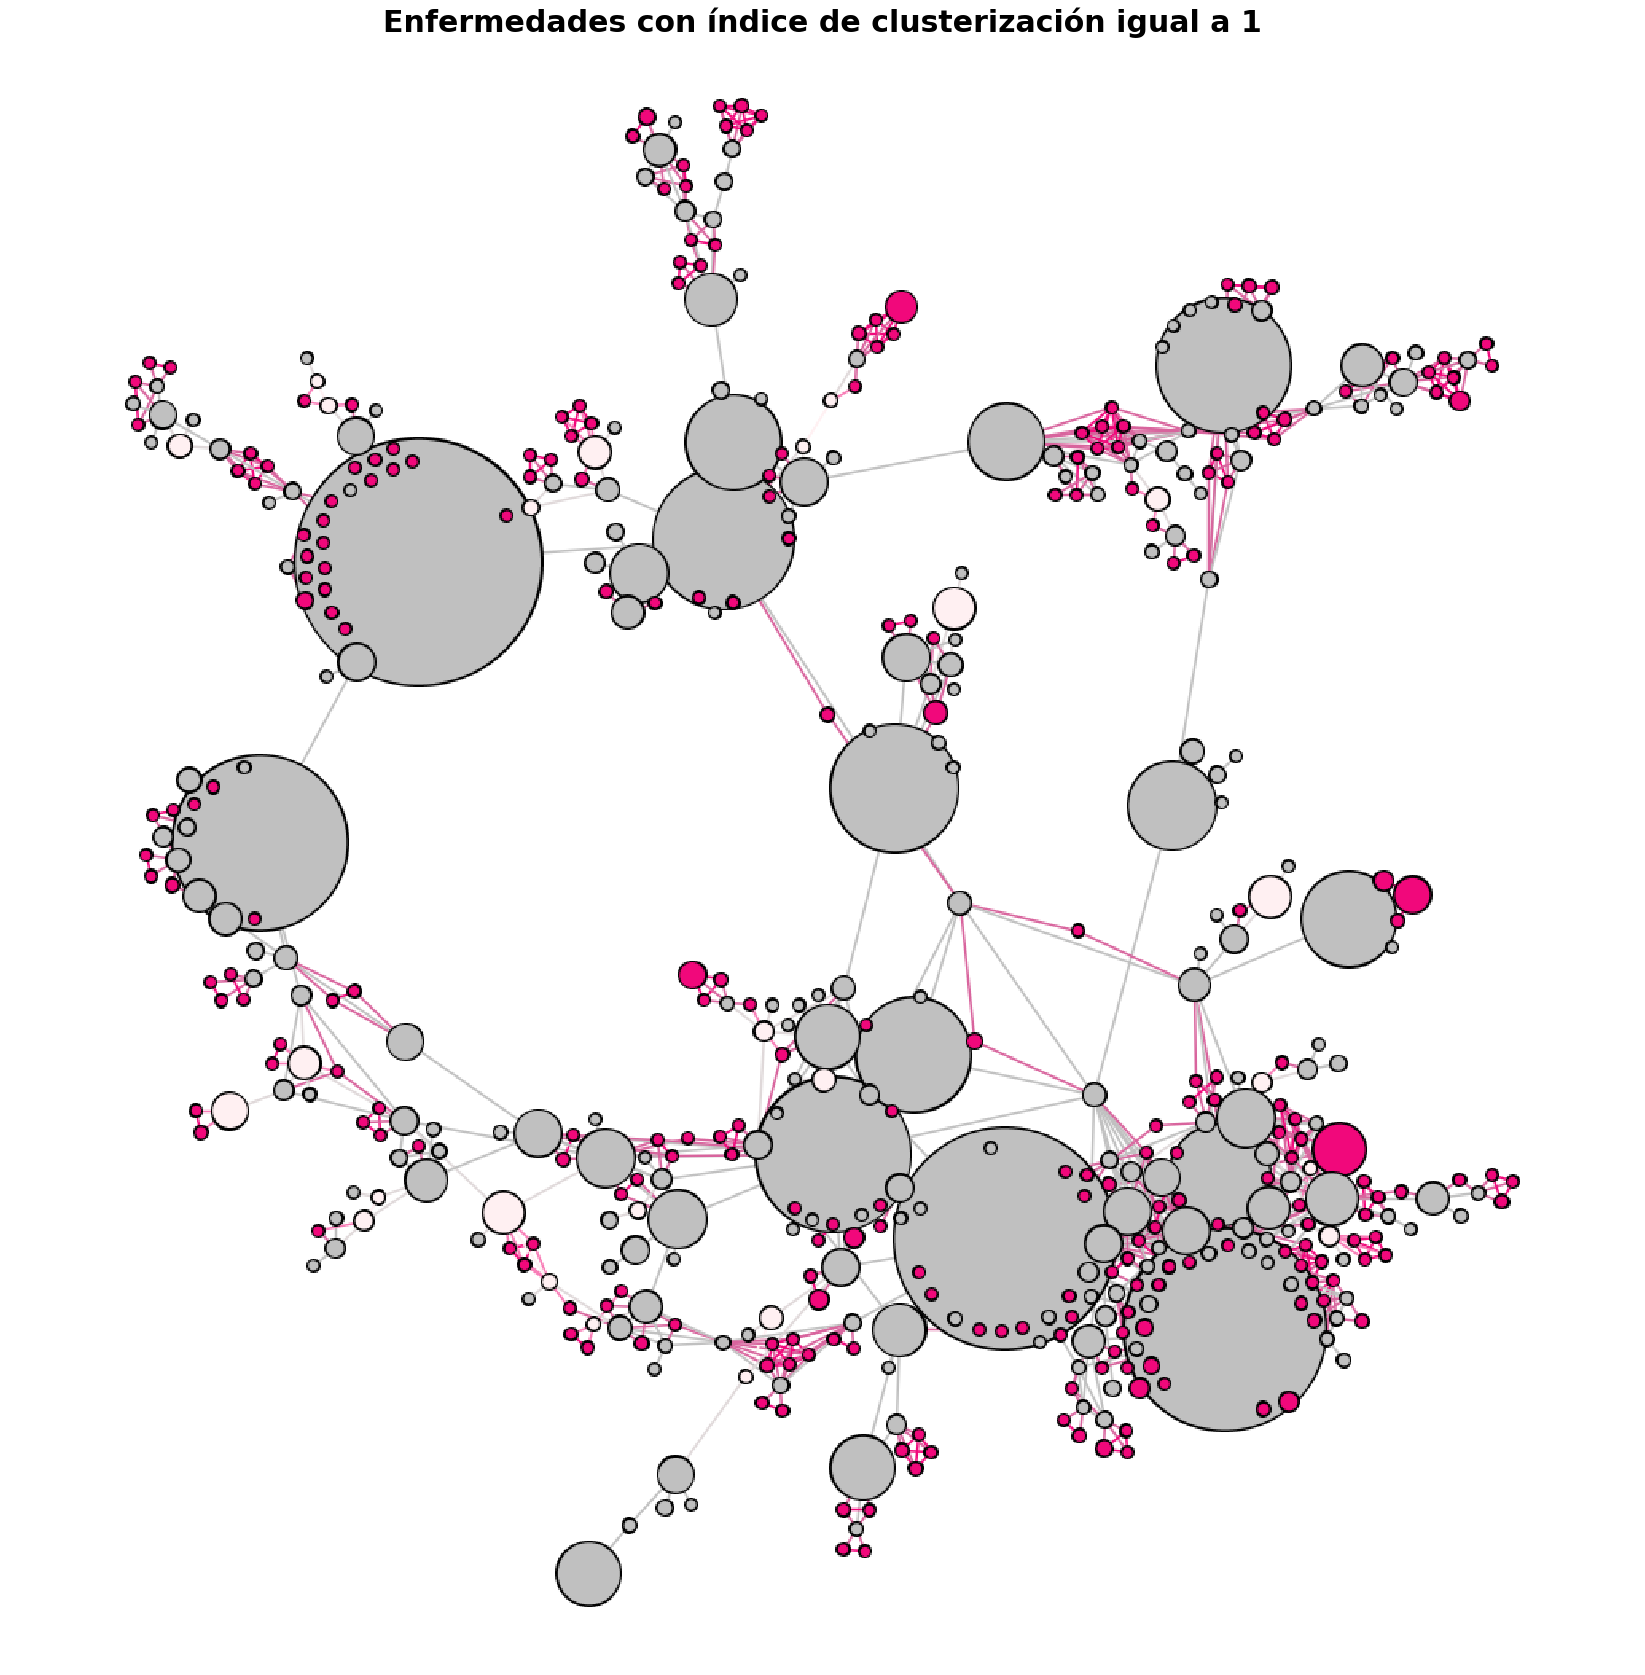

In [251]:
images = []
paths = []

# Seleccionamos los paths a las imagenes
for img_path in glob.glob('./Imagenes/hdn_clustering_1.png'):
    paths.append(img_path)
    
# Ordenamos los archivos
paths.sort()    

# Cargamos las imagenes 
for image in paths:
    images.append(mpimg.imread(image))
    

# ax enables access to manipulate each of subplots
ax = []   
titles = ["Enfermedades con índice de clusterización igual a 1"]
ar_p = np.array([0,0.0001,0.0003,0.0006, 0.001,0.003,0.006,0.01,0.03,0.06,0.1, 0.3,0.6,1.])
fig = plt.figure(figsize=(30,30))
rows = 1
columns = 1
for i, image in enumerate(images):
    ax.append( fig.add_subplot(rows , columns, i+1) )
    ax[-1].set_title(titles[i], fontsize = 30, fontweight = "bold")
    plt.imshow(image)
    plt.axis('off')

In [179]:
# Aleatorio
print("Promedio del índice de clústering medio de grado en el grafo aleatorio: %s, con %s desviación estándar"
      %(dic_params["Clustering"], dic_params["Clustering"][1]))
print()
print("Clustering media del nodo con mayor índice de clustering en el grafo aleatorio: %s, con desviación estándar %s" 
      %(dic_params["Nodo max clustering"][0], dic_params["Nodo max clustering"][1]))

Promedio del índice de clústering medio de grado en el grafo aleatorio: (0.007613115243929196, 0.0027938512134659736), con 0.0027938512134659736 desviación estándar

Clustering media del nodo con mayor índice de clustering en el grafo aleatorio: 0.475, con desviación estándar 0.3085584763595603


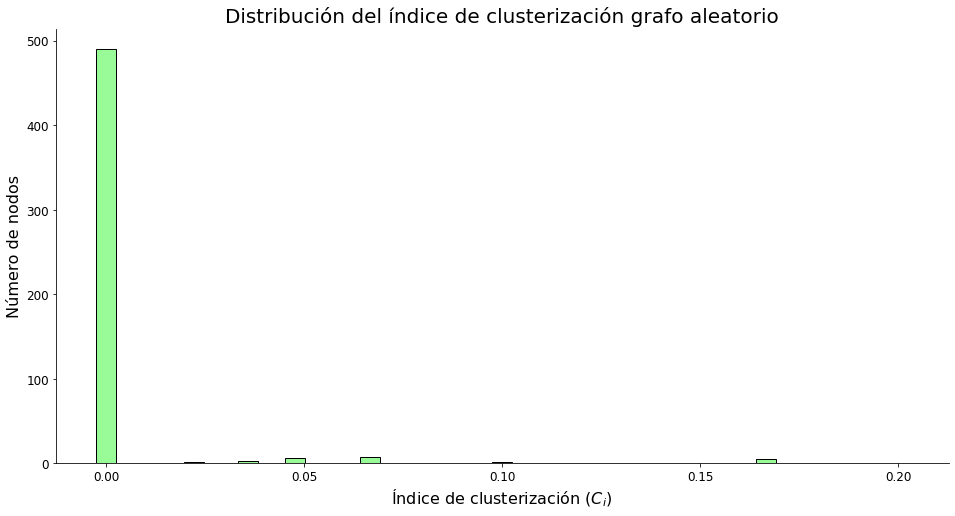

In [220]:
import collections
# Extraemos y ordenamos los valores de índice de clusterizacion
ordenado = sorted(nx.clustering(G_AL).items(), key = lambda pareja: pareja[1], reverse = True)
valores_c = [i[1] for i in ordenado]

freq_c = collections.Counter(valores_c)



plt.figure(figsize = (16, 8))
plt.bar(freq_c.keys(), freq_c.values(), color= col_al, width = 0.005, edgecolor = "black", align = 'center')

# spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# titulo
plt.title("Distribución del índice de clusterización grafo aleatorio", fontsize = 20)

# ejes X y Y
plt.ylabel("Número de nodos", fontsize = 16)
plt.xlabel(r"Índice de clusterización ($C_i$)", fontsize = 16)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)





plt.savefig("./Imagenes/dist_clusterin_aleatorio.png", bbox_inches='tight')

### Camino característico

In [44]:
print("Camino característico -->", nx.average_shortest_path_length(hdn))

Camino característico --> 6.5089937532926925


In [180]:
print("Promedio del número de componentes conexas del grafo aleatorio: %s, con %s desviación estándar"
      %(dic_params["Componentes"][0], dic_params["Componentes"][1]))
print()
print("Promedio del camino mínimo medio de grafo aleatorio: %s, con %s desviación estándar"
      %(dic_params["Shortest path"][0], dic_params["Shortest path"][1]))


Promedio del número de componentes conexas del grafo aleatorio: 6.25, con 2.2332711434127295 desviación estándar

Promedio del camino mínimo medio de grafo aleatorio: 4.234149870220155, con 0.026885491428501565 desviación estándar


### Comparación de la distribución de grado

El grado de un nodo es una propiedad local de la red pero considerandola secuencia de grados podemos determinar algunas propiedades globalesde la red.


En el caso de la red aleatoria, se observa un pico que está centrado entorno a $<k>$ lo que quiera decir que casi todos los nodos de la red aleatoria tienen el mismo número de conexiones. Debido a esta característica se habla de una distribución de grados homogénea.

Por el contrario, la Human Disease Network muestra una distribución de grado que no se encuentra centrada en el valor de grado medio. La función de distribución de grado sigue una ley de potencias, que es independiente de la escala de la red. De este modo, no se trata de una red homogénea, sino de una red en la que la mayoría de los nodos tienen pocas conexiones y, hay unos pocos nodos que tienen muchas. 

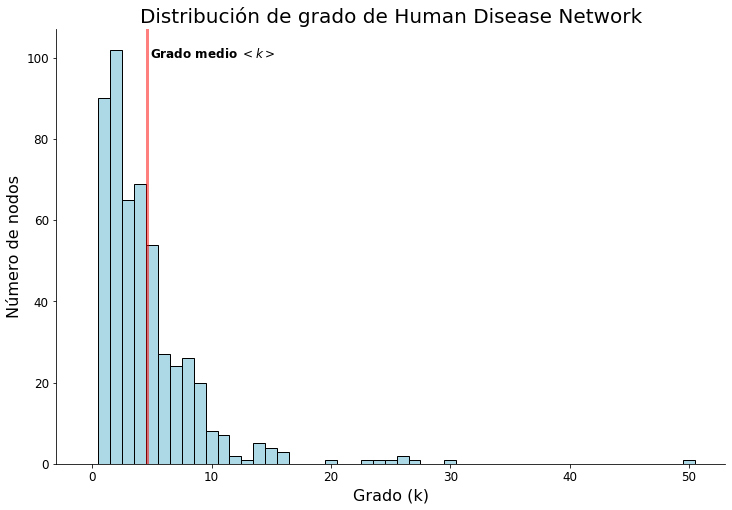

In [63]:
## Distribucion del grado de los nodos del grafo inicial
L=nx.degree_histogram(hdn)

# tamaño figura
plt.figure(figsize = (12, 8))
plt.bar(range(len(L)),L, color= col_hdn, width = 1, edgecolor = "black", align = 'center')

# spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# titulo
plt.title("Distribución de grado de Human Disease Network", fontsize = 20)

# ejes X y Y
plt.ylabel("Número de nodos", fontsize = 16)
plt.xlabel("Grado (k)", fontsize = 16)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)

plt.axvline(4.6047, c = "r", linewidth = 3, alpha = 0.5)
plt.annotate(r'Grado medio $<k>$', (4.8,100), fontsize = 12, fontweight = "bold")



plt.savefig("./Imagenes/dist_grado_hdn.png", bbox_inches='tight')

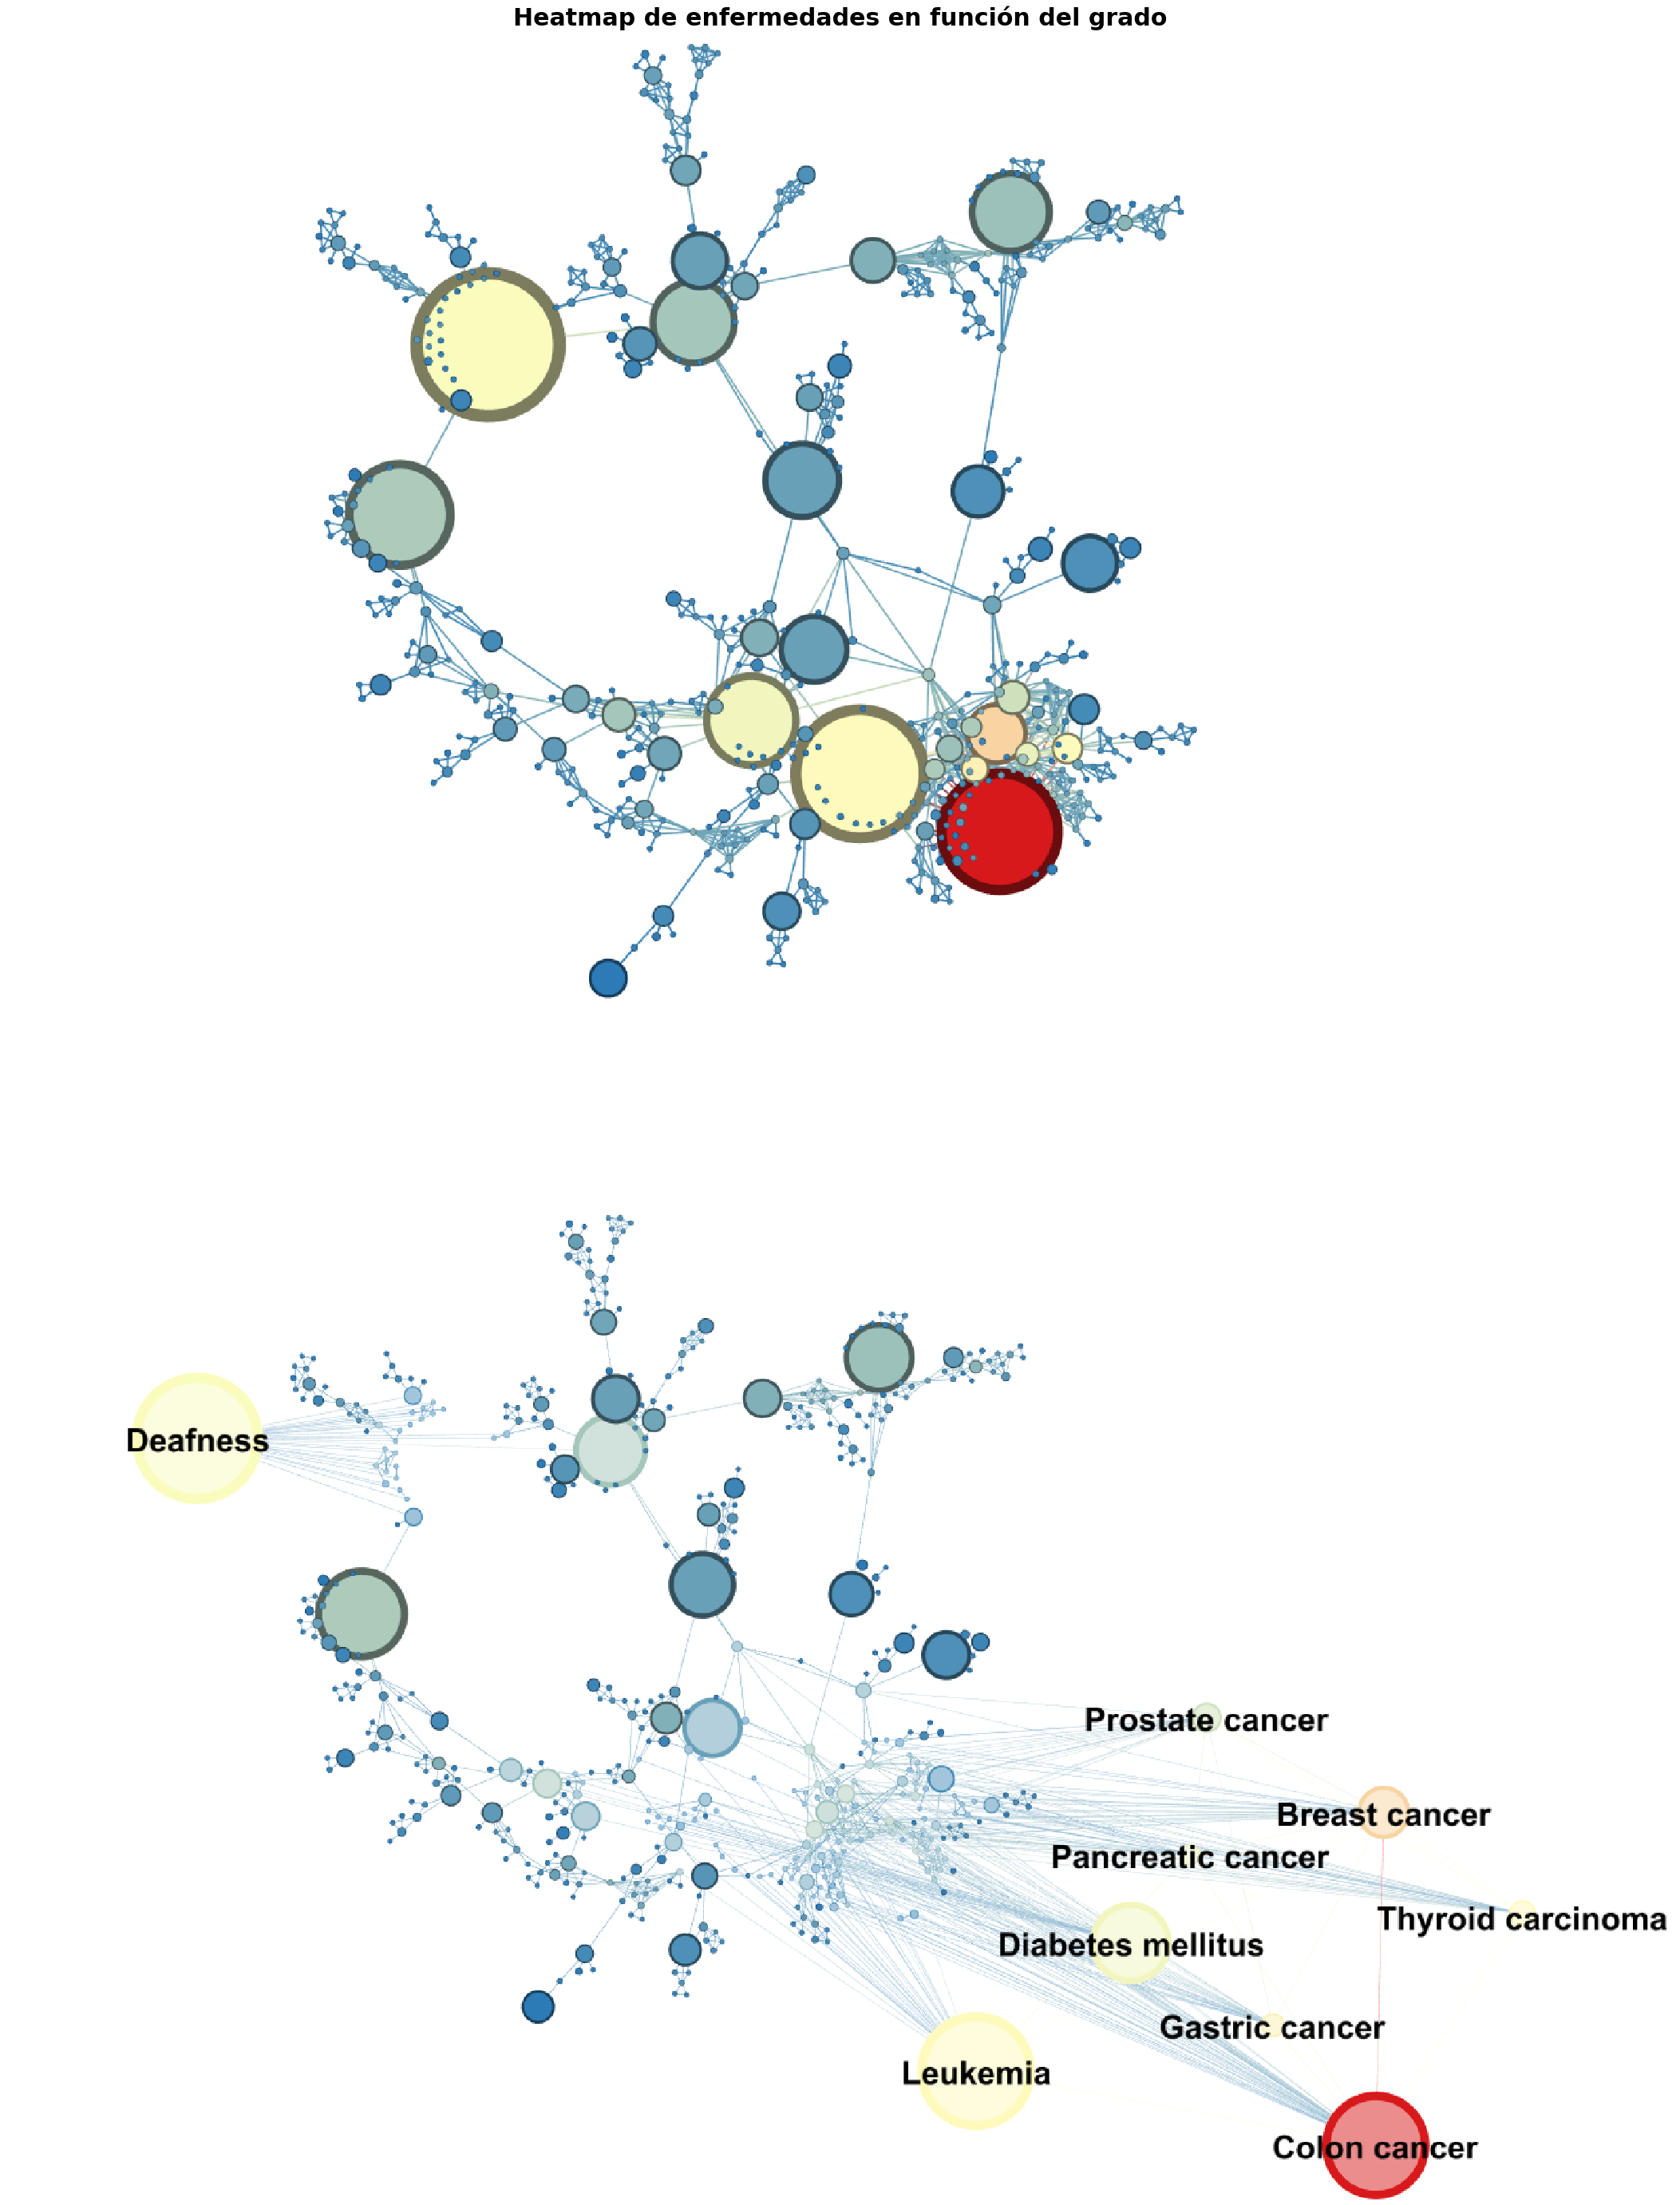

In [14]:
images = []
paths = []

# Seleccionamos los paths a las imagenes
for img_path in glob.glob('./Imagenes/grado_grafo_no_eti.png'):
    paths.append(img_path)
    
# Ordenamos los archivos
paths.sort()    


paths = ['./Imagenes/grado_grafo_no_eti.png', "./Imagenes/grado_grafo_eti.png"]
# Cargamos las imagenes 
for image in paths:
    images.append(mpimg.imread(image))
    

# ax enables access to manipulate each of subplots
ax = []   
titles = ["Heatmap de enfermedades en función del grado", ""]
ar_p = np.array([0,0.0001,0.0003,0.0006, 0.001,0.003,0.006,0.01,0.03,0.06,0.1, 0.3,0.6,1.])
fig = plt.figure(figsize=(50,50))
rows = 2
columns = 1
for i, image in enumerate(images):
    ax.append( fig.add_subplot(rows , columns, i+1) )
    ax[-1].set_title(titles[i], fontsize = 30, fontweight = "bold")
    plt.imshow(image)
    plt.axis('off')

Se han nombrado aquellos nodos que tienen un grado 20 o superior. Corresponden a aquellas enfermedades que presentan mayor número de vecinos que el resto. 

| Enfermedad        	| Clase           	| Grad0 	|
|-------------------	|-----------------	|-------	|
| Colon cancer      	| Cancer          	| 50    	|
| Breast cancer     	| Cancer          	| 30    	|
| Gastric cancer    	| Cancer          	| 27    	|
| Leukemia          	| Cancer          	| 26    	|
| Thyroid carcinoma 	| Cancer          	| 26    	|
| Deafness          	| Ear,Nose,Throat 	| 25    	|
| Diabetes mellitus 	| Endocrine       	| 24    	|
| Pancreatic cancer 	| Cancer          	| 23    	|
| Prostate cancer   	| Cancer          	| 20    	|

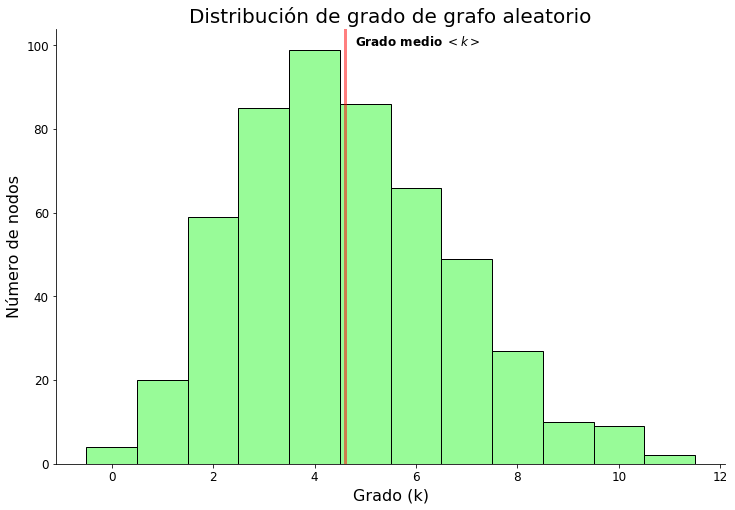

In [227]:
## Distribucion del grado de los nodos del grafo inicial
L=nx.degree_histogram(G_AL)

# tamaño figura
plt.figure(figsize = (12, 8))
plt.bar(range(len(L)),L, color=col_al, width = 1, edgecolor = "black", align = 'center')

# spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# titulo
plt.title("Distribución de grado de grafo aleatorio", fontsize = 20)

# ejes X y Y
plt.ylabel("Número de nodos", fontsize = 16)
plt.xlabel("Grado (k)", fontsize = 16)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)

plt.axvline(4.6047, c = "r", linewidth = 3, alpha = 0.5)
plt.annotate(r'Grado medio $<k>$', (4.8,100), fontsize = 12, fontweight = "bold")


plt.savefig("./Imagenes/dist_grado_aleatorio.png", bbox_inches='tight')

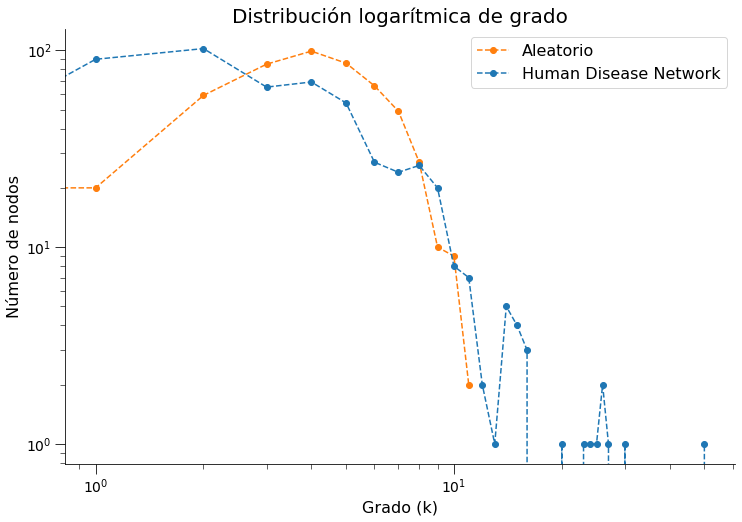

In [223]:
AL = nx.degree_histogram(G_AL)
CE = nx.degree_histogram(hdn)

# Tamaño de la figura
plt.figure(figsize = (12, 8))

# Distribución de grado de grafo aleatorio
plt.plot(range(len(AL)), AL, linestyle='--', marker='o', color='tab:orange', label = "Aleatorio")
# Distribución de grado de grafo de C. elegans
plt.plot(range(len(CE)), CE, linestyle='--', marker='o', color='tab:blue', label = "Human Disease Network")

# Titulo
plt.title("Distribución logarítmica de grado", fontsize = 20)

# spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# ejes X y Y
plt.ylabel("Número de nodos", fontsize = 16)
plt.xlabel("Grado (k)", fontsize = 16)
plt.xscale("log", nonposx = 'clip')
plt.yscale("log", nonposy = 'clip')
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)

# parametros de los ticks
plt.tick_params(axis="both", which = "minor", direction="out", length = 5)
plt.tick_params(axis="both", which = "major", direction="out", length = 10)

# leyenda
plt.legend(loc = "best", fontsize = 16)

plt.show()

### K cores

In [74]:
k_core = nx.core_number(hdn)

# Nodo con mayor valor de centralidad de grado
mayor = max(k_core.values())
print("Máximo k-core de HDN: %d" % mayor)

Máximo k-core de HDN: 10


## Calcular camino más corto entre k-core 10 y k-core 9

In [97]:
# En k = 9 mete también a k = 10. Extraigo los que solo tienen k = 9 y k = 8
k_10 = nx.k_core(hdn, k=10).nodes()
k_9_10 = nx.k_core(hdn, k=9).nodes()
k_9 = []
for i in k_9_10:
    if i not in k_10:
        k_9.append(i)
        
# Ya tengo los nodos k-core 10 y k-core 9
# voy a buscar el camino más corto entre ellos. Me quedaré con el de menor distancia
distancias = []
for nodo_10 in k_10:
    for nodo_9 in k_9:
        distancias.append((nodo_10, nodo_9, nx.shortest_path_length(hdn, source = nodo_10, target = nodo_9)))

# Saco los nodos que menor distancia tienen
min_path_k10_9 = min(distancias, key = lambda k: k[2])

print("Camino más corto entre k-core 10 y k-core 9")
print(hdn.node[min_path_k10_9[0]])
print(hdn.node[min_path_k10_9[1]])
print(min_path_k10_9[2])

Camino más corto entre k-core 9 y k-core 10
{'Disease': 'Hepatic adenoma', 'Class': 'Cancer'}
{'Disease': 'Cataract', 'Class': 'Ophthamological'}
5


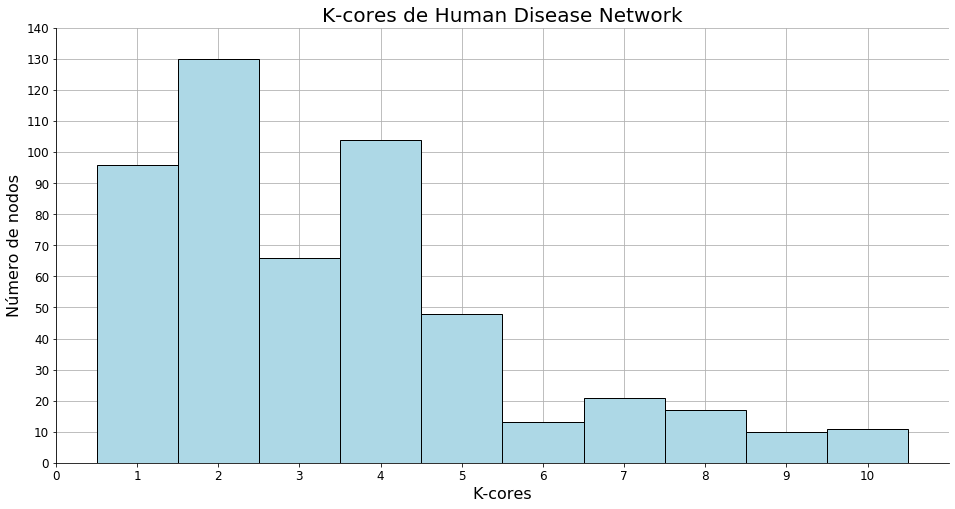

In [69]:
k_cores = collections.Counter(nx.core_number(hdn).values())

plt.figure(figsize = (16, 8))

plt.grid()
plt.bar(k_cores.keys(), k_cores.values(), color= col_hdn, width = 1, edgecolor = "black", align = 'center')

# spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.rc('axes', axisbelow=True)

# titulo
plt.title("K-cores de Human Disease Network", fontsize = 20)

# ejes X y Y
plt.ylabel("Número de nodos", fontsize = 16)
plt.xlabel(r"K-cores", fontsize = 16)
plt.xticks(range(0, 11), fontsize = 12)
plt.yticks(range(0, 150, 10), fontsize = 12)

plt.savefig("./Imagenes/dist_kcore_hdn.png", bbox_inches='tight')

In [65]:
print("Promedio del k-core medio en el grafo aleatorio: %s, con %s desviación estándar"
      %(dic_params["Max k-core"][0], dic_params["Max k-core"][1]))

Promedio del k-core medio en el grafo aleatorio: 3.0, con 0.0 desviación estándar


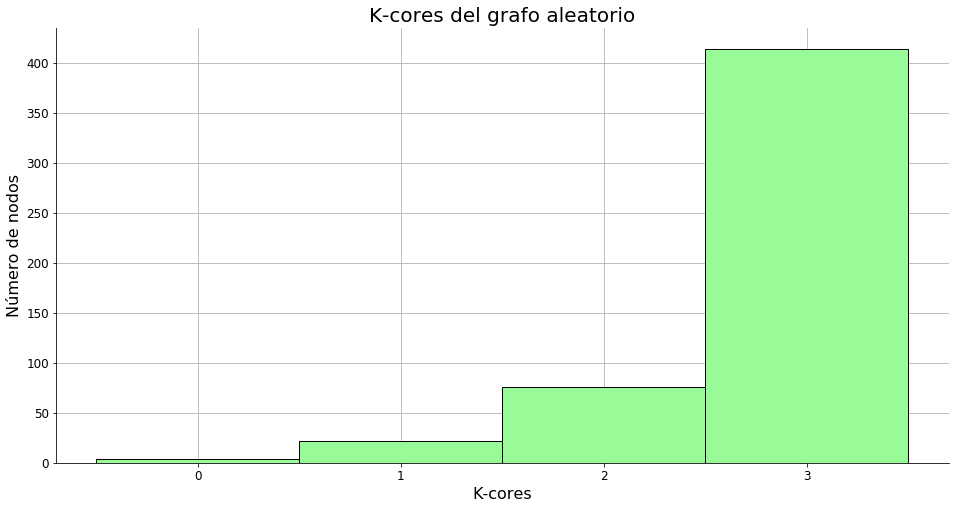

In [72]:
k_cores = collections.Counter(nx.core_number(G_AL).values())

plt.figure(figsize = (16, 8))

plt.grid()
plt.bar(k_cores.keys(), k_cores.values(), color=col_al, width = 1, edgecolor = "black", align = 'center')

# spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.rc('axes', axisbelow=True)

# titulo
plt.title("K-cores del grafo aleatorio", fontsize = 20)

# ejes X y Y
plt.ylabel("Número de nodos", fontsize = 16)
plt.xlabel(r"K-cores", fontsize = 16)
plt.xticks(range(0, 4), fontsize = 12)
plt.yticks(range(0, 430, 50), fontsize = 12)

plt.savefig("./Imagenes/dist_kcore_aleatorio.png", bbox_inches='tight')

## Distancia k core 10 a k core 7

In [122]:
# En k = 9 mete también a k = 10. Extraigo los que solo tienen k = 9 y k = 8
k_10 = nx.k_core(hdn, k=10).nodes()
k_9_10 = nx.k_core(hdn, k=9).nodes()
k_9 = []
for i in k_9_10:
    if i not in k_10:
        k_9.append(i)
        
k_7 = ["227", "742", "772", "773", "769", "770", "771", "774"]
# Ya tengo los nodos k-core 10 y k-core 9
# voy a buscar el camino más corto entre ellos. Me quedaré con el de menor distancia
distancias = []
for nodo_10 in k_10:
    for nodo_7 in k_7:
        distancias.append((nodo_10, nodo_7, nx.shortest_path_length(hdn, source = nodo_10, target = nodo_7)))

# Saco los nodos que menor distancia tienen
min_path_k10_7 = min(distancias, key = lambda k: k[2])

print("Camino más corto entre k-core 10 y k-core 7")
print(hdn.node[min_path_k10_7[0]])
print(hdn.node[min_path_k10_7[1]])
print(min_path_k10_7[2])


distancias = []
for nodo_9 in k_9:
    for nodo_7 in k_7:
        distancias.append((nodo_9, nodo_7, nx.shortest_path_length(hdn, source = nodo_9, target = nodo_7)))

# Saco los nodos que menor distancia tienen
min_path_k9_7 = min(distancias, key = lambda k: k[2])

print("Camino más corto entre k-core 9 y k-core 7")
print(hdn.node[min_path_k9_7[0]])
print(hdn.node[min_path_k9_7[1]])
print(min_path_k9_7[2])

Camino más corto entre k-core 10 y k-core 7
{'Disease': 'Pancreatic cancer', 'Class': 'Cancer'}
{'Disease': 'Lipoma', 'Class': 'Cancer'}
2
Camino más corto entre k-core 9 y k-core 7
{'Disease': 'Cataract', 'Class': 'Ophthamological'}
{'Disease': 'Lipoma', 'Class': 'Cancer'}
7


## Conclusiones del análisis inicial

* La red se compone de 516 nodos (orden) y 1188 aristas (tamaño)


* Es un grafo no dirigido


* Es un grafo disperso (densidad = 0.009)


* Es un grado conexo


* El diámetro del grafo es 15. 


* El grado medio del grafo es 4.6047


* El camino característico es 6.5089


## Conclusiones comparación con grafo aleatorio

* La red aleatoria no aparece conectada, mientras que la Human Disease Network sí lo está


* La distribución de grado de HDN sigue una ley de potencias, por lo que es una red libre de escala. 



* Centralidad de grado media 

    * Human Disease Network
        *  Valor medio: $0.00894$
        *  Nodo con mayor centralidad: {'Disease': 'Colon cancer', 'Class': 'Cancer'}, ($0.097$)
        
    * Aleatorio
        * Valor: $0.00894 \pm 5e-18$
        * Nodo con mayor centralidad: $0.024 \pm 0.0023$


* Cercanía 

    * Human Disease Network
        *  Valor medio: $0.15937$
        *  Nodo con mayor centralidad: {'Disease': 'Lipodystrophy', 'Class': 'Metabolic'}, ($0.2518$)
        
    * Aleatorio
        * Valor medio: $0.23318 \pm 0.00162$
        * Nodo con mayor centralidad: $0.28637\pm 0.00554$

* Intermediación

    * Human Disease Network
        *  Valor medio: $0.0107178$
        *  Nodo con mayor centralidad: {'Disease': 'Cardiomyopathy', 'Class': 'Cardiovascular'}, ($0.4693$)
        
    * Aleatorio
        * Valor medio: $ 0.006 \pm  9e-05$
        * Nodo con mayor centralidad: $0.034 \pm 0.0048$
        
      
        
* Índice de clusterización

    * Human Disease Network
        *  Valor medio: $0.6358$
        *  Nodo con mayor centralidad:  {'Disease': 'Morning glory disc anomaly', 'Class': 'Skeletal'}, ($1.0$)
        
    * Aleatorio
        * Valor medio: $ 0.0076 \pm 0.0027$
        * Nodo con mayor centralidad: $0.475 \pm 0.31$
 
 
* Camino característico

    * Human Disease Network
        *  Valor : $6.508$
        
    * Aleatorio
        * Valor medio de camino mínimo de la componente gigante: $ 4.234 \pm 0.026$
        
        
* K core

    * Human Disease Network
        *  Mayor k core : $10$
        
    * Aleatorio
        * Mayor k core: $ 3 \pm 0.0$
        

## Análisis de nodos importantes

### Nodos importantes en función del grado


| Enfermedad        	| Clase           	| Grad0 	|
|-------------------	|-----------------	|-------	|
| Colon cancer      	| Cancer          	| 50    	|
| Breast cancer     	| Cancer          	| 30    	|
| Gastric cancer    	| Cancer          	| 27    	|
| Leukemia          	| Cancer          	| 26    	|
| Thyroid carcinoma 	| Cancer          	| 26    	|
| Deafness          	| Ear,Nose,Throat 	| 25    	|
| Diabetes mellitus 	| Endocrine       	| 24    	|
| Pancreatic cancer 	| Cancer          	| 23    	|
| Prostate cancer   	| Cancer          	| 20    	|

### Nodos importante en función del k-core 

#### K core 10

| Enfermedad                   	| Clase  	|
|------------------------------	|--------	|
| Colon cancer                 	| Cancer 	|
| Breast cancer                	| Cancer 	|
| Thyroid carcinoma            	| Cancer 	|
| Pancreatic cancer            	| Cancer 	|
| Hepatic adenoma              	| Cancer 	|
| Li-Fraumeni syndrome         	| Cancer 	|
| Osteosarcoma                 	| Cancer 	|
| Adrenal cortical carcinoma   	| Cancer 	|
| Histiocytoma                 	| Cancer 	|
| Multiple malignancy syndrome 	| Cancer 	|
| Nasopharyngeal carcinoma     	| Cancer 	|

#### K core 9

| Enfermedad                     	| Clase           	|
|--------------------------------	|-----------------	|
| Cataract                       	| Ophthamological 	|
| Peters anomaly                 	| Developmental   	|
| Ectopia                        	| Ophthamological 	|
| Coloboma, ocular               	| Ophthamological 	|
| Aniridia, type II              	| Ophthamological 	|
| Eye anomalies                  	| Ophthamological 	|
| Foveal hypoplasia              	| Ophthamological 	|
| Keratitis                      	| Ophthamological 	|
| Morning glory disc anomaly     	| Skeletal        	|
| Optic nerve hypoplasia/aplasia 	| Ophthamological 	|

###  Camino más corto entre  K-core 10 y K-core 9. 

Camino más corto entre k-core 9 y k-core 10 --> 5


{'Disease': 'Hepatic adenoma', 'Class': 'Cancer'} --> {'Disease': 'Cataract', 'Class': 'Ophthamological'}


Vemos que la distancia es corta). 

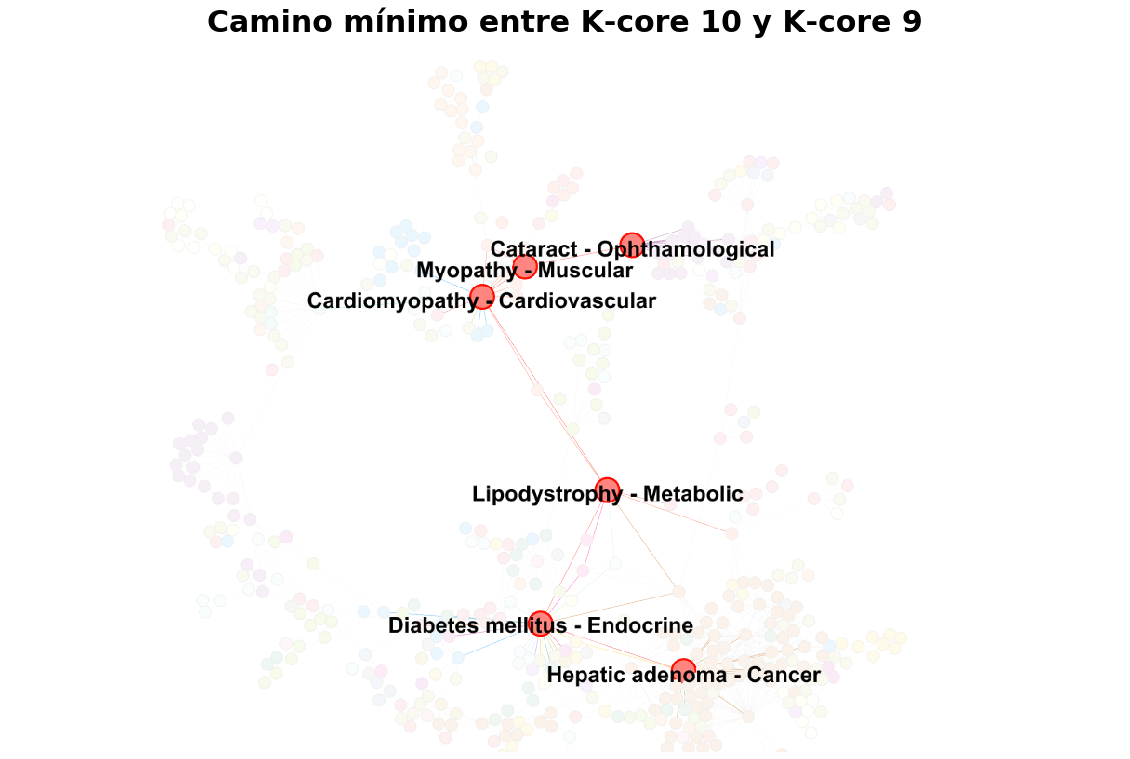

In [119]:
images = []
paths = []
paths = ['./Imagenes/k_core/camino2_k9_k10.png', ]
# Cargamos las imagenes 
for image in paths:
    images.append(mpimg.imread(image))
ax = []   
titles = ["Camino mínimo entre K-core 10 y K-core 9", ""]
fig = plt.figure(figsize=(20,20))
rows = 1
columns = 1
for i, image in enumerate(images):
    ax.append( fig.add_subplot(rows , columns, i+1) )
    ax[-1].set_title(titles[i], fontsize = 30, fontweight = "bold")
    plt.imshow(image)
    plt.axis('off')

### Evolución k core

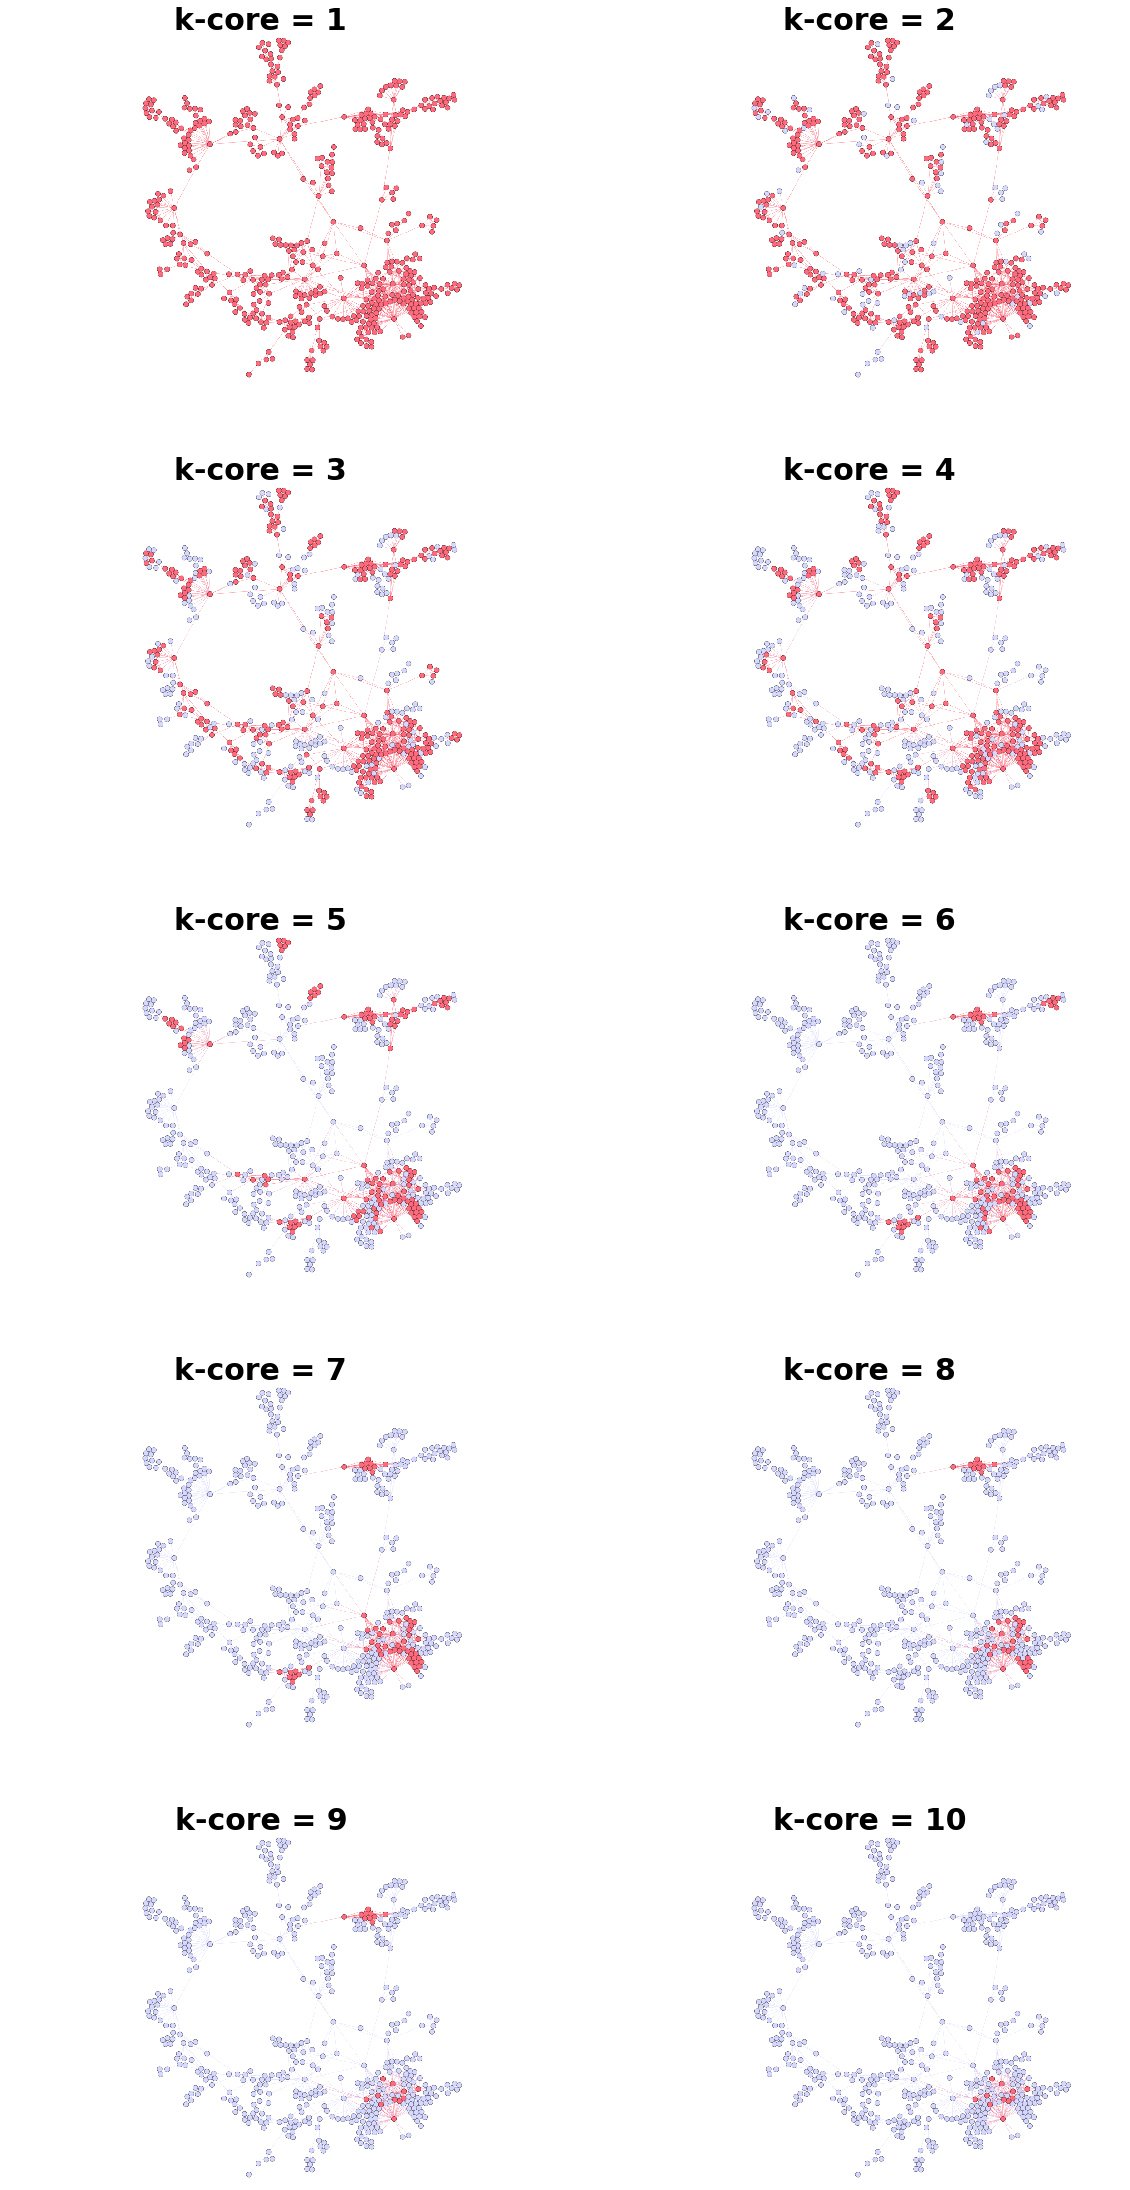

In [120]:
images = []
paths = []

# Seleccionamos los paths a las imagenes
for img_path in glob.glob('./Imagenes/k_core/evolucion/*.png'):
    paths.append(img_path)
    
# Ordenamos los archivos
paths.sort()    

# Cargamos las imagenes 
for image in paths:
    images.append(mpimg.imread(image))
    

# ax enables access to manipulate each of subplots
ax = []   
ar_p = np.array([1, 2, 3, 4,5, 6,7 ,8, 9, 10])
fig = plt.figure(figsize=(20,40))
rows = 5
columns = 2
for i, image in enumerate(images):
    ax.append( fig.add_subplot(rows , columns, i+1) )
    ax[-1].set_title("k-core = "+str(ar_p[i]), fontsize = 30, fontweight = "bold")
    plt.imshow(image)
    plt.axis('off')
    
plt.savefig("./Imagenes/evo_k_core.png", bbox_inches='tight', dpi = 600)

# Epidemia: propagación por la red

In [17]:
import networkx as nx
import EoN
import matplotlib.pyplot as plt
from random import choice

# Nodo seleccionado vs Nodo aleatorio

Veremos cómo una infección dirigida consigue esparcirse de forma más rápida a través de la red, que una infección que comience de forma aleatoria. La simulación se para cuando se ha alcanzado el máximo valor, 516, correspondiente al número total de nodos de la red. Por tanto, se podrá comprobar qué criterio de infección alcanza antes el máximo valor y, en consecuencia, permite una dispersión más rápida a traveś de la red. 

El nodo seleccionado para el ataque dirigido es el "Colon Cancer", nodo con mayor grado, mayor centralidad de grado, pertenciente a un 10-core, con mayor número de triángulos y mayor índice de Page Rank

In [132]:
G = hdn

tau = 0.1 #tasa de transmision
gamma = 0 # tasa de recuperacion


# Nodo con mayor grado - Colon Cancer
nodo1 = max(G.degree, key = lambda k: k[1])[0]
info1 = hdn.nodes[nodo1]
print(nodo1, info1)

initial_infecteds_1 = [nodo1] # nodo inicial de la infeccion

t1, S1, I1, R1 = EoN.fast_SIR(G, tau, gamma, initial_infecteds= initial_infecteds_1)

# Nodo aleatorio
nodo2, info2 = choice(list(dict(G.nodes()).items() ) )
print(nodo2, info2)
initial_infecteds_2 = [nodo2]

t2, S2, I2, R2 = EoN.fast_SIR(G, tau, gamma, initial_infecteds= initial_infecteds_2)

# Nodo aleatorio 2
nodo3, info3 = choice(list(dict(G.nodes()).items() ) )
print(nodo3, info3)
initial_infecteds_3 = [nodo3]

t3, S3, I3, R3 = EoN.fast_SIR(G, tau, gamma, initial_infecteds= initial_infecteds_3)

114 {'Disease': 'Colon cancer', 'Class': 'Cancer'}
283 {'Disease': 'Caffey disease', 'Class': 'Connective tissue disorder'}
941 {'Disease': 'Bannayan-Riley-Ruvalcaba syndrome', 'Class': 'Unclassified'}


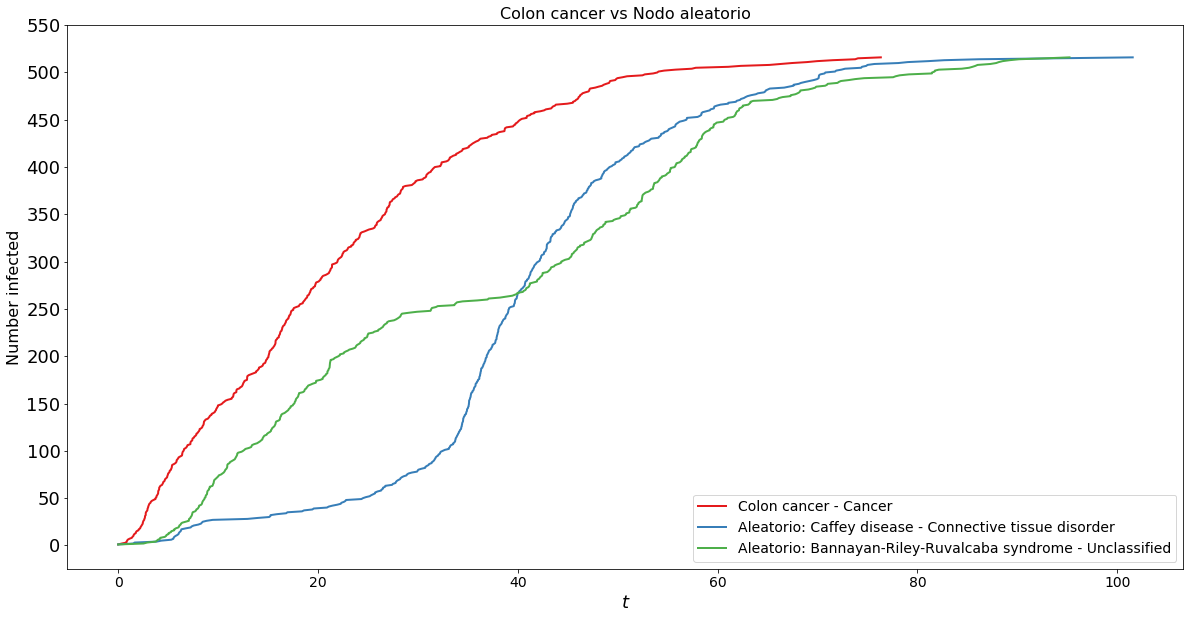

In [133]:
plt.figure(figsize = (20, 10))


colors = plt.cm.Set1(np.linspace(0, 1, 10))

plt.plot(t1, I1, label = list(info1.items())[0][1]+" - "+list(info1.items())[1][1], 
         c = colors[0], linewidth = 2)


plt.plot(t2, I2, label = "Aleatorio: "+list(info2.items())[0][1]+" - "+list(info2.items())[1][1], 
         c = colors[1], linewidth = 2)

plt.plot(t3, I3, label = "Aleatorio: "+list(info3.items())[0][1]+" - "+list(info3.items())[1][1], 
         c = colors[2], linewidth = 2)

plt.xlabel("$t$", fontsize = 18)
plt.ylabel("Number infected", fontsize = 16)
plt.legend(loc = "lower right", fontsize = 14)
plt.title(list(info1.items())[0][1]+" vs "+ "Nodo aleatorio", fontsize = 16)
plt.xticks(fontsize = 14)
plt.yticks(np.arange(0, 600, 50), fontsize = 18)
# plt.savefig("./Imagenes/Infeccion/Selec_vs_Random.png", bbox_inches='tight')
plt.show()

# Nodo seleccionados 

En este caso estudiaremos qué aproximación es más interesante para infectar más rápido la red o, si por el contrario, no hay diferencia entre ellas. Las aproximaciones que se van a emplear para dirigir la infección serán las obtenidas a partir de los nodos identificados anteriormente con un mayor valor de algún parámetro:

Nodos importantes:

* **Colon cancer - Cancer** --> Nodo con mayor centralidad de grado, 10-core, mayor nº de triángulos, mayor grado y mayor índice Page Rank. 


* **Lipodystrophy - Metabolic** --> Forma parte del radio, tiene el mayor valor de cercanía y es el baricentro. Por este nodo se encuentra el camino más corto entre el 10-core y el 9-core. Pertenece a su vez a un 4-core.  


* **Cardiomiopathy - Cardiovascular** --> Nodo con mayor valor de intermediación. En los ataques dirigidios por grado e intermediación es uno de los 4 nodos que más cambios provoca en el tamaño de la componente conexa. Pertenece a su vez a un 4-core.  


* **Pancreatic Cancer - Cancer** --> Nodo perteneciente al 10-core. Es el nodo del 10-core que más próximo se encuentra al 7-core. En los ataques dirigidios por grado e intermediación es uno de los 4 nodos que más cambios provoca en el tamaño de la componente conexa. Presenta 74 triángulos y presenta grado 23. 


* **Hepatic adenoma - Cancer** --> Nodo del 10-core más cercano al 9-core. Posee 51 triángulos, un grado 16 y un índice de clusterización de 0.425. 


* **Cataract - Ophthamological** --> Nodo del 9-core más cercano al 7-core y el 10-core. 


* **Lipoma - Cancer** --> Nodo del 7-core más cercano al 10-core. Posee un índice de clusterización 0.49 y grado 10. 


Podemos ver la predominancia del Cancer en la red, dado que 4 de los nodos 7 identificados como importantes pertenecen a esta clase. Luego 1 a enfermedades cardiovasculares, 1  metabólicas y otro a oftalmológicas. 


In [189]:
G = hdn
tau = 0.2 #tasa de transmision
gamma = 0 # tasa de recuperacion

# Colon Cancer
nodo1 = "114"
info1 = hdn.nodes[nodo1]
print(nodo1, info1)
initial_infecteds_1 = [nodo1] # nodo inicial de la infeccion
t1, S1, I1, R1 = EoN.fast_SIR(G, tau, gamma, initial_infecteds= initial_infecteds_1, tmax = 100)

# Lipodystrophy
nodo2 = "736" 
info2 = hdn.nodes[nodo2]
print(nodo2, info2)
initial_infecteds_2 = [nodo2]
t2, S2, I2, R2 = EoN.fast_SIR(G, tau, gamma, initial_infecteds= initial_infecteds_2, tmax = 100)

# Cardiomyopathy
nodo3 = "54"
info3 = hdn.nodes[nodo3]
print(nodo3, info3)
initial_infecteds_3 = [nodo3] # nodo inicial de la infeccion
t3, S3, I3, R3 = EoN.fast_SIR(G, tau, gamma, initial_infecteds= initial_infecteds_3, tmax = 100)

# Pancreatic cancer
nodo4 = "59"
info4 = hdn.nodes[nodo4]
print(nodo4, info4)
initial_infecteds_4 = [nodo4] # nodo inicial de la infeccion
t4, S4, I4, R4 = EoN.fast_SIR(G, tau, gamma, initial_infecteds= initial_infecteds_4, tmax = 100)

# Hepatic adenoma
nodo5 = "224"
info5 = hdn.nodes[nodo5]
print(nodo5, info5)
initial_infecteds_5 = [nodo5] # nodo inicial de la infeccion
t5, S5, I5, R5 = EoN.fast_SIR(G, tau, gamma, initial_infecteds= initial_infecteds_5, tmax = 100)

# Cataract
nodo6 = "325"
info6 = hdn.nodes[nodo6]
print(nodo6, info6)
initial_infecteds_6 = [nodo6] # nodo inicial de la infeccion
t6, S6, I6, R6 = EoN.fast_SIR(G, tau, gamma, initial_infecteds= initial_infecteds_6, tmax = 100)

# Lipoma 
nodo7 = "742"
info7 = hdn.nodes[nodo7]
print(nodo7, info7)
initial_infecteds_7 = [nodo7] # nodo inicial de la infeccion
t7, S7, I7, R7 = EoN.fast_SIR(G, tau, gamma, initial_infecteds= initial_infecteds_7, tmax = 100)

# Random 
nodo8, info8 = choice(list(dict(G.nodes()).items() ) )
print(nodo8, info8)
initial_infecteds_8 = [nodo8]

t8, S8, I8, R8 = EoN.fast_SIR(G, tau, gamma, initial_infecteds= initial_infecteds_8, tmax = 100)

114 {'Disease': 'Colon cancer', 'Class': 'Cancer'}
736 {'Disease': 'Lipodystrophy', 'Class': 'Metabolic'}
54 {'Disease': 'Cardiomyopathy', 'Class': 'Cardiovascular'}
59 {'Disease': 'Pancreatic cancer', 'Class': 'Cancer'}
224 {'Disease': 'Hepatic adenoma', 'Class': 'Cancer'}
325 {'Disease': 'Cataract', 'Class': 'Ophthamological'}
742 {'Disease': 'Lipoma', 'Class': 'Cancer'}
1198 {'Disease': 'Netherton syndrome', 'Class': 'Dermatological'}


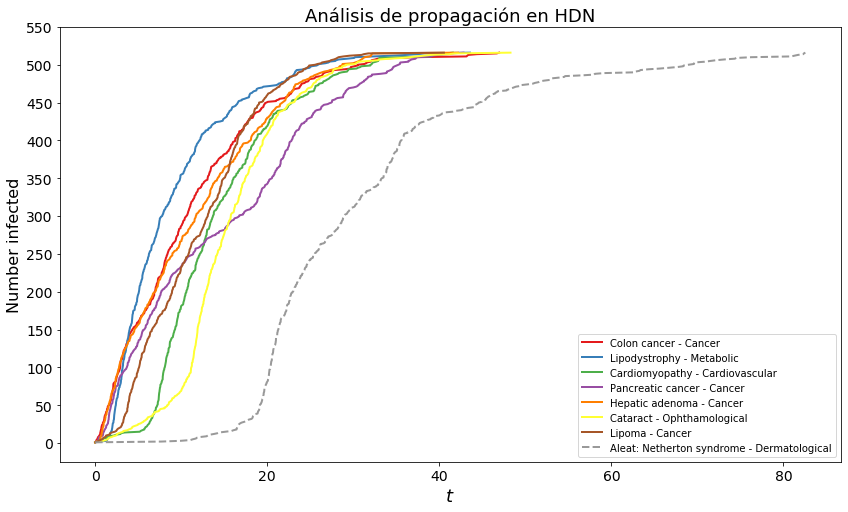

In [190]:
plt.figure(figsize = (14, 8))

colors = plt.cm.Set1(np.linspace(0, 1, 10))

plt.plot(t1, I1, label = list(info1.items())[0][1]+" - "+list(info1.items())[1][1], 
         c = colors[0], linewidth = 2)

plt.plot(t2, I2, label = list(info2.items())[0][1]+" - "+list(info2.items())[1][1],   
         c = colors[1], linewidth = 2)

plt.plot(t3, I3, label = list(info3.items())[0][1]+" - "+list(info3.items())[1][1], 
         c = colors[2], linewidth = 2)

plt.plot(t4, I4, label = list(info4.items())[0][1]+" - "+list(info4.items())[1][1], 
         c = colors[3], linewidth = 2)

plt.plot(t5, I5, label = list(info5.items())[0][1]+" - "+list(info5.items())[1][1], 
         c = colors[4], linewidth = 2)

plt.plot(t6, I6, label = list(info6.items())[0][1]+" - "+list(info6.items())[1][1], 
         c = colors[5], linewidth = 2)

plt.plot(t7, I7, label = list(info7.items())[0][1]+" - "+list(info7.items())[1][1], 
         c = colors[6], linewidth = 2)

plt.plot(t8, I8, label = "Aleat: "+list(info8.items())[0][1]+" - "+list(info8.items())[1][1], 
         c = colors[9], linewidth = 2, linestyle = "--")

plt.xlabel("$t$", fontsize = 18)
plt.ylabel("Number infected", fontsize = 16)
plt.legend(loc = "lower right", fontsize = 10)
plt.title("Análisis de propagación en HDN", fontsize = 18)
plt.xticks(fontsize = 14)
plt.yticks(np.arange(0, 600, 50), fontsize = 14)
plt.savefig("./Imagenes/Infeccion/Seleccionados4.png", bbox_inches='tight')
plt.show()

Algo importante ha señalar es que en este tipo de estudio, no sólo nos interesa conocer cómo de rápido se propaga una "infección" por la red HDN, sino que también nos interesa observar la topología de la curva. La topología de la curva nos muestra cómo es el perfil de la propagación a partir de un nodo determinado y, algo muy importante, se conserva en distintas iteraciones. 

Por su parte el tiempo en el que se alcanza la totalidad de los nodos para cada nodo seleccionado puede variar en cada iteración. Esto dificulta la comparación, pero sí nos indica que seguir un criterio de selección de nodos, aunque no nos asegura el mejor de los ataques, nos permite propagarnos rápidamente por la red. 

In [206]:
images = []
paths = []

# Seleccionamos los paths a las imagenes
for img_path in glob.glob('./Imagenes/Infeccion/Seleccionados*.png'):
    paths.append(img_path)
    
# Ordenamos los archivos
paths.sort()    

# Cargamos las imagenes 
for image in paths:
    images.append(mpimg.imread(image))
    

# ax enables access to manipulate each of subplots
ax = []   
ar_p = np.array([1, 2, 3, 4])
fig = plt.figure(figsize=(300, 150))
rows = 2
columns = 2
for i, image in enumerate(images):
    ax.append( fig.add_subplot(rows , columns, i+1) )
    ax[-1].set_title("Análisis de propagación en HDN: "+str(ar_p[i]), fontsize = 100, fontweight = "bold")
    plt.imshow(image)
    plt.axis('off')

    
# plt.savefig("./Imagenes/Infeccion/figura.png", bbox_inches='tight', dpi = 600)

## Captura de la epidemia a un tiempo

Hemos visto que uno de los nodos que mayor velocidad de propagación presenta normalmente es la Lipodystrophy.También se ha estudiado Colon Cancer, Cariomyiopathy y Cataract. Veamos como se lleva a cabo la propagación:

736 {'Disease': 'Lipodystrophy', 'Class': 'Metabolic'}
doing Gillespie simulation
done with simulation, now plotting


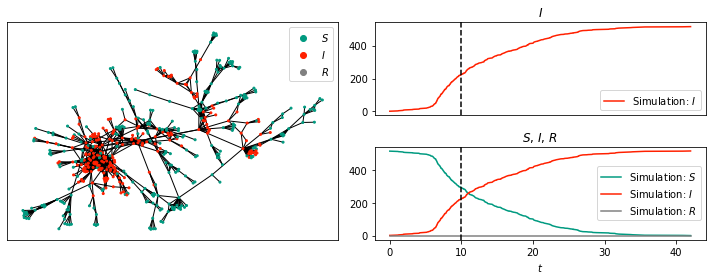

In [229]:
G =  hdn

nx_kwargs = {"with_labels":True}

tau = 0.2 #transmission rate
gamma = 0 #recovery rate
# Nodo aleatorio
nodo2 = "736" 
info2 = hdn.nodes[nodo2]
print(nodo2, info2)
initial_infecteds_2 = [nodo2]


print("doing Gillespie simulation")
sim = EoN.fast_SIR(G, tau, gamma, initial_infecteds= initial_infecteds_2, return_full_data=True)
# t1, S1, I1, R1 = EoN.fast_SIR(G, tau, gamma, initial_infecteds= initial_infecteds_1, tmax = 50)
print("done with simulation, now plotting")

sim.display(time = 10, node_size = 4, ts_plots=['I', 'SIR'] )#plot at time 1.
plt.savefig("./Imagenes/Infeccion/foto_red/lipodistrofia.png", bbox_inches='tight')
plt.show()

114 {'Disease': 'Colon cancer', 'Class': 'Cancer'}
doing Gillespie simulation
done with simulation, now plotting


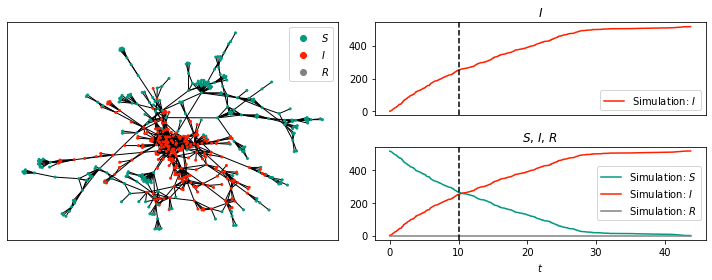

In [230]:
G =  hdn

nx_kwargs = {"with_labels":True}

tau = 0.2 #transmission rate
gamma = 0 #recovery rate
# Colon cancer
nodo2 = "114" 
info2 = hdn.nodes[nodo2]
print(nodo2, info2)
initial_infecteds_2 = [nodo2]


print("doing Gillespie simulation")
sim = EoN.fast_SIR(G, tau, gamma, initial_infecteds= initial_infecteds_2, return_full_data=True)
# t1, S1, I1, R1 = EoN.fast_SIR(G, tau, gamma, initial_infecteds= initial_infecteds_1, tmax = 50)
print("done with simulation, now plotting")

sim.display(time = 10, node_size = 4, ts_plots=['I', 'SIR'] )#plot at time 1.
plt.savefig("./Imagenes/Infeccion/foto_red/colon.png", bbox_inches='tight')
plt.show()

54 {'Disease': 'Cardiomyopathy', 'Class': 'Cardiovascular'}
doing Gillespie simulation
done with simulation, now plotting


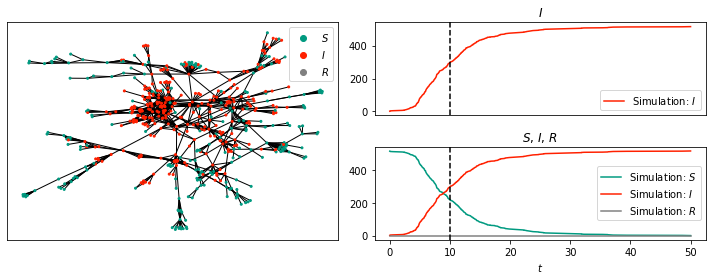

In [231]:
G =  hdn

nx_kwargs = {"with_labels":True}

tau = 0.2 #transmission rate
gamma = 0 #recovery rate
# Cardiomiopatia
nodo2 = "54" 
info2 = hdn.nodes[nodo2]
print(nodo2, info2)
initial_infecteds_2 = [nodo2]


print("doing Gillespie simulation")
sim = EoN.fast_SIR(G, tau, gamma, initial_infecteds= initial_infecteds_2, return_full_data=True)
# t1, S1, I1, R1 = EoN.fast_SIR(G, tau, gamma, initial_infecteds= initial_infecteds_1, tmax = 50)
print("done with simulation, now plotting")

sim.display(time = 10, node_size = 4, ts_plots=['I', 'SIR'] )#plot at time 1.
plt.savefig("./Imagenes/Infeccion/foto_red/cardiomiopatia.png", bbox_inches='tight')
plt.show()

325 {'Disease': 'Cataract', 'Class': 'Ophthamological'}
doing Gillespie simulation
done with simulation, now plotting


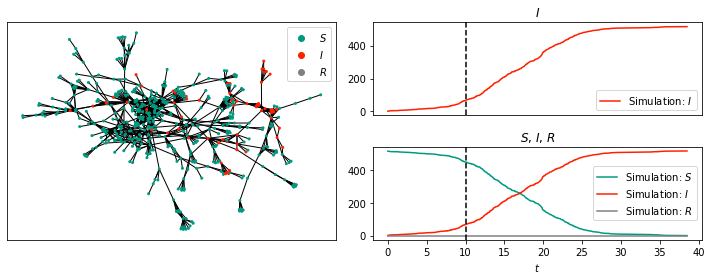

In [232]:
G =  hdn

nx_kwargs = {"with_labels":True}

tau = 0.2 #transmission rate
gamma = 0 #recovery rate
# Cataract
nodo2 = "325" 
info2 = hdn.nodes[nodo2]
print(nodo2, info2)
initial_infecteds_2 = [nodo2]


print("doing Gillespie simulation")
sim = EoN.fast_SIR(G, tau, gamma, initial_infecteds= initial_infecteds_2, return_full_data=True)
# t1, S1, I1, R1 = EoN.fast_SIR(G, tau, gamma, initial_infecteds= initial_infecteds_1, tmax = 50)
print("done with simulation, now plotting")

sim.display(time = 10, node_size = 4, ts_plots=['I', 'SIR'] )#plot at time 1.
plt.savefig("./Imagenes/Infeccion/foto_red/cataract.png", bbox_inches='tight')
plt.show()

## Video

736 {'Disease': 'Lipodystrophy', 'Class': 'Metabolic'}
doing Gillespie simulation
done with simulation, now plotting


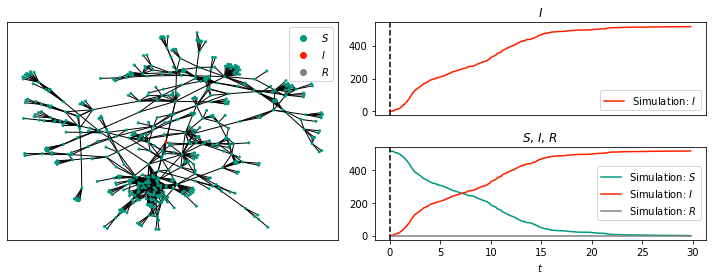

In [223]:
G =  hdn

nx_kwargs = {"with_labels":True}

tau = 0.3 #transmission rate
gamma = 0 #recovery rate

nodo2 = "736" 
info2 = hdn.nodes[nodo2]
print(nodo2, info2)
initial_infecteds_2 = [nodo2]

print("doing Gillespie simulation")
sim = EoN.fast_SIR(G, tau, gamma, initial_infecteds= initial_infecteds_2, return_full_data=True)
# t1, S1, I1, R1 = EoN.fast_SIR(G, tau, gamma, initial_infecteds= initial_infecteds_1, tmax = 50)
print("done with simulation, now plotting")

ani=sim.animate(ts_plots=['I', 'SIR'], node_size = 4)
ani.save('Lipodistrofia.mp4', fps=5, extra_args=['-vcodec', 'libx264'])

325 {'Disease': 'Cataract', 'Class': 'Ophthamological'}
doing Gillespie simulation
done with simulation, now plotting


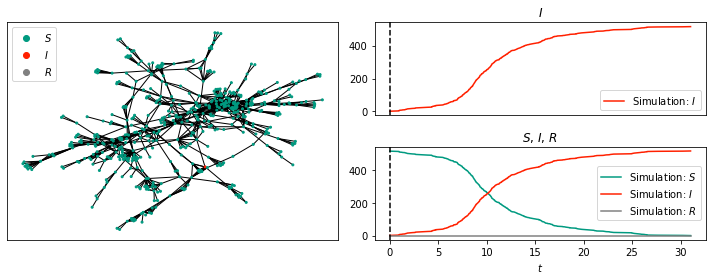

In [233]:
G =  hdn

nx_kwargs = {"with_labels":True}

tau = 0.3 #transmission rate
gamma = 0 #recovery rate

nodo2 = "325" 
info2 = hdn.nodes[nodo2]
print(nodo2, info2)
initial_infecteds_2 = [nodo2]

print("doing Gillespie simulation")
sim = EoN.fast_SIR(G, tau, gamma, initial_infecteds= initial_infecteds_2, return_full_data=True)
# t1, S1, I1, R1 = EoN.fast_SIR(G, tau, gamma, initial_infecteds= initial_infecteds_1, tmax = 50)
print("done with simulation, now plotting")

ani=sim.animate(ts_plots=['I', 'SIR'], node_size = 4)
ani.save('Cataratas.mp4', fps=5, extra_args=['-vcodec', 'libx264'])

54 {'Disease': 'Cardiomyopathy', 'Class': 'Cardiovascular'}
doing Gillespie simulation
done with simulation, now plotting


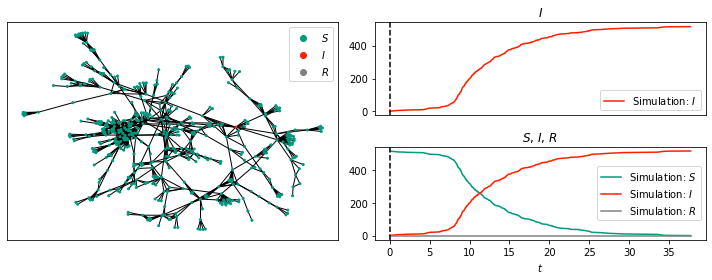

In [234]:
G =  hdn

nx_kwargs = {"with_labels":True}

tau = 0.3 #transmission rate
gamma = 0 #recovery rate

nodo2 = "54" 
info2 = hdn.nodes[nodo2]
print(nodo2, info2)
initial_infecteds_2 = [nodo2]

print("doing Gillespie simulation")
sim = EoN.fast_SIR(G, tau, gamma, initial_infecteds= initial_infecteds_2, return_full_data=True)
# t1, S1, I1, R1 = EoN.fast_SIR(G, tau, gamma, initial_infecteds= initial_infecteds_1, tmax = 50)
print("done with simulation, now plotting")

ani=sim.animate(ts_plots=['I', 'SIR'], node_size = 4)
ani.save('Cardiomiopatia.mp4', fps=5, extra_args=['-vcodec', 'libx264'])

114 {'Disease': 'Colon cancer', 'Class': 'Cancer'}
doing Gillespie simulation
done with simulation, now plotting


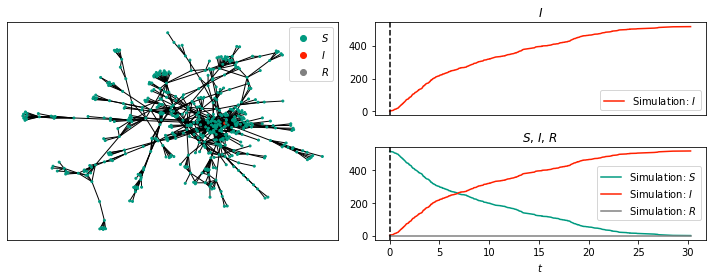

In [224]:
G =  hdn

nx_kwargs = {"with_labels":True}

tau = 0.3 #transmission rate
gamma = 0 #recovery rate

nodo2 = "114" 
info2 = hdn.nodes[nodo2]
print(nodo2, info2)
initial_infecteds_2 = [nodo2]

print("doing Gillespie simulation")
sim = EoN.fast_SIR(G, tau, gamma, initial_infecteds= initial_infecteds_2, return_full_data=True)
print("done with simulation, now plotting")

ani=sim.animate(ts_plots=['I', 'SIR'], node_size = 4)
ani.save('Colon.mp4', fps=5, extra_args=['-vcodec', 'libx264'])

## Jerarquía de la epidemia

También es interesante observar el camino de la infección de forma jerarquizada. No obstante, dado el gran tamaño de la red, visualmente es poco intuitiva. A continuación, se muestra el árbol jerarquizado de la infección del Colon Cancer

366 {'Disease': 'SARS, progression of', 'Class': 'Immunological'}
doing Gillespie simulation


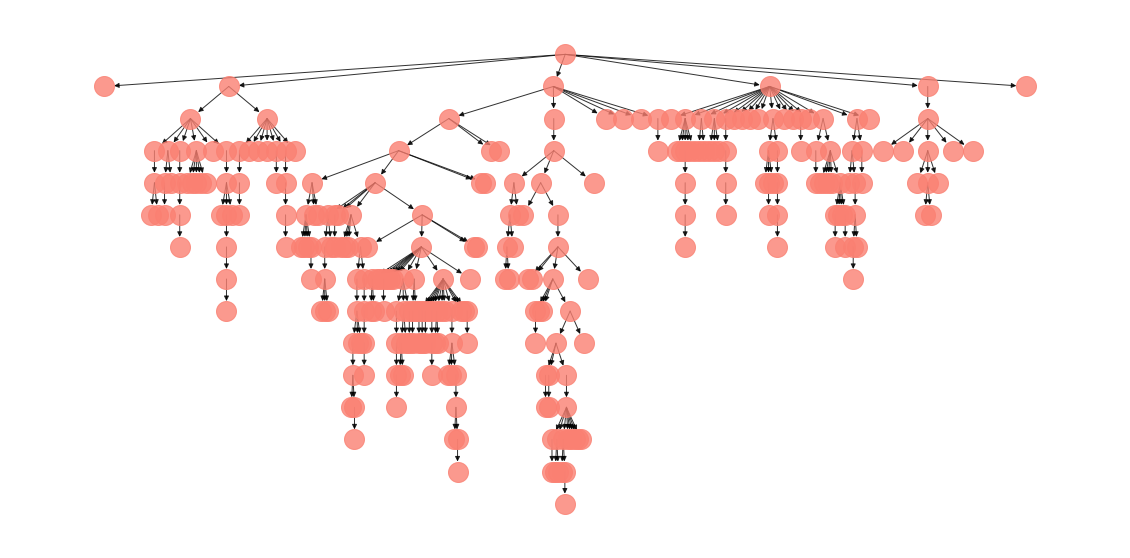

In [990]:
G =  hdn
# G = nx.karate_club_graph()

nx_kwargs = {"with_labels":True, "node_size":500, "node_color ":"red"}

tau = 0.3 #transmission rate
gamma = 0.5 #recovery rate
nodo2 = "114" 
info2 = hdn.nodes[nodo2]
print(nodo2, info2)
initial_infecteds_2 = ["114"]


print("doing Gillespie simulation")
#sim = EoN.Gillespie_SIR(G, tau, gamma, rho = 0.005, return_full_data=True)
sim = EoN.Gillespie_SIR(G, 1, 1, initial_infecteds= initial_infecteds_2, return_full_data=True)

T = sim.transmission_tree()
Tpos = EoN.hierarchy_pos(T)

fig = plt.figure(figsize = (20,10))
ax = fig.add_subplot(111)
nx.draw(T, Tpos, ax=ax, node_size = 400, with_labels=False, node_color = "salmon", alpha = 0.8,
       font_size = 20)
plt.show()

# Ataques aleatorios a la red

Debemos ver como las redes aleatorias y las mixtas (small world y libre de escala) son resistentes a ataques aleatorios. Aún así, sí se puede observar que en las mixtas el daño es algo mayor, puesto que se observa saltos (caídas) más drásticas del tamaño de la componente conexa de mayor tamaño al quitar algunos nodos. Estos saltos se corresponden precisamente a la eliminación de nodos que tienen mayor número de ramas que el resto. Los saltos no se producen en una red aleatoria porque la distribución de de grado sigue una distribución de Poisson y, por tanto, homogénea. 

**Los siguientes ataques son aproximados, no grantizan el mejor ataque posible**

In [73]:
from random import choice
import copy
def failure(Grafo, eje_x = "frac_nodos"):
    """
    Objetivo: Ataque aleatorio a redes eliminando progresivamente nodos
    
    Resumen: Se realizan tanta iteraciones como nodos-1 tenga el grafo. En cada iteración se selecciona
             y elimina un nodo y sus ramas de forma aleatoria del grafo inicial.
             
             La función almacena el número de nodos, ramas o la fracción de nodos o ramas eliminadas en cada iteración, al igual que el tamaño relativo
             de la componente conexa más grande tras eliminar el nodo.
             Finalmente, se almacena la variación del tamaño de la componente conexa en cada iteración. Estos
             resultados permiten al usuario visualizar qué nodos han provocado más daño en la red. 
             
             ADVERTENCIA: el daño a la red de cada nodo depende del nodo anterior. Es decir, el daño producido
             por un mismo nodo a la red, depende de los nodos eliminados anteriormente. 
             
             Se puede representar el tamaño de la componente conexa (CC) a medida que eliminamos nodos del grafo
    
    Argumentos:
        Grafo (network x graph): grafo de network x sobre el que realizar el ataque
        eje_x (string): Representar efecto del ataque en función del número de ramas eliminadas, 
                        número de nodos eliminados, fracción de ramas eliminadas o fracción de nodos eliminados
                        (default = "nodos")(Posibles valores: "frac_nodos", "frac_ramas", "nodos", "ramas")
                
        
    Return: 
        x (list): fracción de ramas / nodos eliminados
        y (list): tamaño relativo de la componente conexa más grande (normalizada por el tamaño inicial)
        nodos_eliminados (list): almacenamiento de la iteración, el nodo y la información del nodo eliminado
        saltos (list): lista de tuplas del valor del eje X, el nodo y la caída del tamaño de la componente conexa
                       en cada iteración. 
    """
    G = copy.deepcopy(Grafo)
    max_cc = nx.Graph(G.subgraph(max(nx.connected_components(G), key=len)))
    
    # Almacenamiento resultados
    x = [0] # Fracción de ramas eliminadas
    y = [1] # Tamaño relativo de la componente conexa más grande
    nodos_eliminados = []

    # Variables
    n = nx.number_of_nodes(G) # Numero de nodos iniciales
    r_inicial_grafo = nx.number_of_edges(G) # Numero de ramas iniciales
    r_inicial_cc = nx.number_of_edges(max_cc)
   
    
    saltos = [] # almacenaré la magnitud de la caida del tamaño
    
    j = 1
    
    while j < n: # iteramos hasta quitar todos los nodos
        
        # No actualizamos la componente conexa más grande. Mantenemos la referencia
        

        # Selección aleatoria de un nodo
        nodo, info = choice(list(dict(G.nodes()).items() ) ) # de todo el grafo
        nodos_eliminados.append((j, nodo, info))
        
        # Eliminación del nodo y sus ramas incidentes de la componente conexa. 
        # Si no es posible eliminarla 
        G.remove_node(n = nodo)

        # Número de ramas en el grafo total tras la eliminación
        r_restantes_grafo = nx.number_of_edges(G)
        fra_el = (r_inicial_grafo - r_restantes_grafo) / r_inicial_grafo
        
        max_cc = nx.Graph(G.subgraph(max(nx.connected_components(G), key=len)))
        # Numero de ramas en la componente conexa tras la eliminacion
        r_cc = nx.number_of_edges(max_cc) 
    
        if eje_x == "nodos":
             x.append( j )
        
        if eje_x == "ramas":
            x.append( b-a )
        
        # Fracción de nodos eliminados
        if eje_x == "frac_nodos":
            x.append( j/n )
        
        # Fracción de ramas eliminadas
        if eje_x == "frac_ramas":
            x.append( fra_el )
        
        # Tamaño relativo de la componente conexa más grande
        y.append( r_cc / r_inicial_cc )
        
       
        
        # Anoto la magnitud de la caida (salto) del tamaño
        if j == 1:
            saltos.append( (x[j], Grafo.nodes[nodo], 1 - y[j]) ) # Guardo en una tupla la pos del eje x y la magnitud de la caída
        else:
            saltos.append( (x[j], Grafo.nodes[nodo], y[j-1] - y[j]) ) 
    
        j += 1
        
    return x, y, nodos_eliminados, saltos  

## Ataque aleatorio a la red HDN

Análisis de robustez: Tamaño relativo de la componente conexa vs la fracción de ramas eliminadas. Vemos como el grafo correspondiente a uno de libre de escala y de mundo pequeño aguanta ataques aleatorios. El sesgo biológico precisamente está relacionado con esta resistencia. 

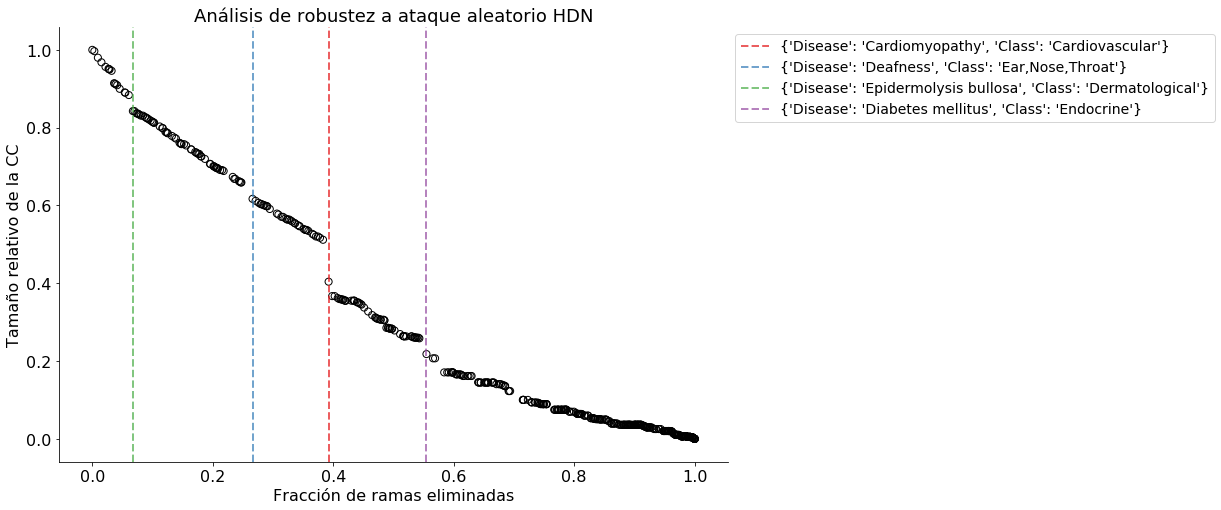

In [814]:
# HDN
x, y, eliminados, saltos = failure(hdn, eje_x = "frac_ramas")

plt.figure(figsize = (12, 8))
plt.scatter(x, y, marker = 'o', s = 50, facecolors='none', edgecolor = "black")

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

colors = plt.cm.Set1(np.linspace(0, 1, 10))
for i, color in zip(sorted(saltos, key = lambda k: k[2], reverse = True )[:4], colors):
    plt.axvline(i[0], c = color, label = i[1], alpha = 0.7, linestyle = "--", linewidth = 2)

plt.title("Análisis de robustez a ataque aleatorio HDN", fontsize = 18)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)

plt.xlabel("Fracción de ramas eliminadas", fontsize = 16)
plt.ylabel("Tamaño relativo de la CC", fontsize = 16)
    
plt.legend(bbox_to_anchor=(1, 1), fontsize = 14)
# plt.savefig("./Imagenes/Ataques/HDN_ataque_aleatorio.png", bbox_inches='tight')
plt.show()

## Ataque aleatorio a la red aleatoria

Análisis de robustez: Tamaño relativo de la componente conexa vs la fracción de ramas eliminadas

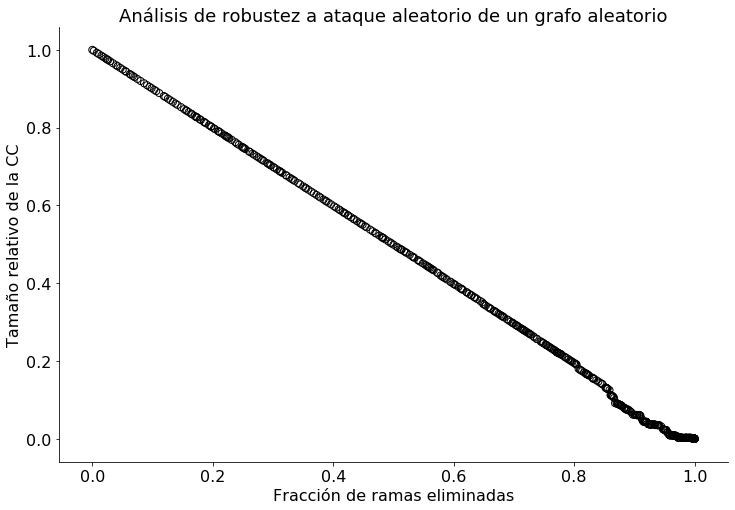

In [77]:
# Aleatoria
x, y, eliminados, saltos = failure(G_AL, eje_x = "frac_ramas")

plt.figure(figsize = (12, 8))
plt.scatter(x, y, marker = 'o', s = 50, facecolors='none', edgecolor = "black")

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)


plt.title("Análisis de robustez a ataque aleatorio de un grafo aleatorio", fontsize = 18)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)

plt.xlabel("Fracción de ramas eliminadas", fontsize = 16)
plt.ylabel("Tamaño relativo de la CC", fontsize = 16)
    
# plt.legend(bbox_to_anchor=(1.6, 1), fontsize = 14)
# plt.savefig("./Imagenes/Ataques/AL_ataque_aleatorio.png", bbox_inches='tight')
plt.show()

# Ataques dirigidos en función del grado

Las redes aleatorias son las que más aguantan a todo tipo de ataque. El ataque a grado tampoco les supondrá un gran impacto dado que la distribución de grado sigue una Poisson, es decir, el grado de los distintos nodos es homogéneo entre sí. 

No obstante, en los grafos mixtos, existen nodos con un mayor grado que el resto. En consecuencia, el ataque dirigido a grado tendrá un mayor impacto en redes mixtas. No obstante, el impacto no será devastador, dado que una vez se hayan eliminado los nodos con mayor grado (una minoría), los nodos restantes presentan un grado más o meno homogéneo, reduciendo el daño sufrido por la red. 

En el contexto biológico, esto supone que el ataque dirigido nodos en función del grado sólo ha de realizarse en aquellos nodos con un grado significativamente superior al resto, pero no merece la pena gastar recursos atacando a los nodos restantes. Esto puede ser útil en el ámbito clínico, donde en función de la enfermedad (nodo) y el grado que posea (número de genes compartidos con otras enfermedades) la selección del tipo de ataque puede ser diferente. 

In [762]:
G = copy.deepcopy(hdn)
max_cc = nx.Graph(G.subgraph(max(nx.connected_components(G), key=len)))
print(nx.info(max_cc), "\n")
#print(max_cc.nodes())
#print(max_cc.nodes["340"])
#print(max_cc.degree)
nodo2 = max(max_cc.degree, key = lambda k: k[1])[0]
print(max_cc.nodes[nodo2])
na = str(nodo2)
print(na)
max_cc.remove_node("340")
print(nx.info(max_cc), "\n")

Name: Human Disease Network
Type: Graph
Number of nodes: 516
Number of edges: 1188
Average degree:   4.6047 

{'Disease': 'Colon cancer', 'Class': 'Cancer'}
114
Name: Human Disease Network
Type: Graph
Number of nodes: 515
Number of edges: 1186
Average degree:   4.6058 



In [808]:
from random import choice
import copy
def attack_degree(Grafo, eje_x = "frac_nodos"):
    """
    Objetivo: Ataque aleatorio a redes eliminando progresivamente nodos
    
    Resumen: Se realizan tanta iteraciones como nodos-1 tenga el grafo. En cada iteración se selecciona
             y elimina un nodo y sus ramas de forma aleatoria del grafo inicial.
             
             La función almacena el número de nodos, ramas o la fracción de nodos o ramas eliminadas en cada iteración, al igual que el tamaño relativo
             de la componente conexa más grande tras eliminar el nodo.
             Finalmente, se almacena la variación del tamaño de la componente conexa en cada iteración. Estos
             resultados permiten al usuario visualizar qué nodos han provocado más daño en la red. 
             
             ADVERTENCIA: el daño a la red de cada nodo depende del nodo anterior. Es decir, el daño producido
             por un mismo nodo a la red, depende de los nodos eliminados anteriormente. 
             
             Se puede representar el tamaño de la componente conexa (CC) a medida que eliminamos nodos del grafo
    
    Argumentos:
        Grafo (network x graph): grafo de network x sobre el que realizar el ataque
        eje_x (string): Representar efecto del ataque en función del número de ramas eliminadas, 
                        número de nodos eliminados, fracción de ramas eliminadas o fracción de nodos eliminados
                        (default = "nodos")(Posibles valores: "frac_nodos", "frac_ramas", "nodos", "ramas")
                
        
    Return: 
        x (list): fracción de ramas / nodos eliminados
        y (list): tamaño relativo de la componente conexa más grande (normalizada por el tamaño inicial)
        nodos_eliminados (list): almacenamiento de la iteración, el nodo y la información del nodo eliminado
        saltos (list): lista de tuplas del valor del eje X, el nodo y la caída del tamaño de la componente conexa
                       en cada iteración. 
    """
    G = copy.deepcopy(Grafo)
    max_cc = nx.Graph(G.subgraph(max(nx.connected_components(G), key=len)))
    
    # Almacenamiento resultados
    x = [0] # Fracción de ramas eliminadas
    y = [1] # Tamaño relativo de la componente conexa más grande
    nodos_eliminados = []

    # Variables
    n = nx.number_of_nodes(G) # Numero de nodos iniciales
    r_inicial_grafo = nx.number_of_edges(G) # Numero de ramas iniciales X
    r_inicial_cc = nx.number_of_edges(max_cc) # Numero de ramas iniciales en la componente mas grande Y
   
    
    saltos = [] # almacenaré la magnitud de la caida del tamaño
    
    j = 1
    
    while j < n: # iteramos hasta quitar todos los nodos
        
        

        # Selección aleatoria de un nodo
        nodo = max(G.degree, key = lambda k: k[1])[0] # de todo el grafo
        info = dict(list(G.nodes().items()))[max(G.degree, key = lambda k: k[1])[0]]
        nodos_eliminados.append((j, nodo, info))
        
        # Eliminación del nodo y sus ramas incidentes de la componente conexa. 
        # Si no es posible eliminarla 
        G.remove_node(n = nodo)

        # Número de ramas en el grafo total tras la eliminación
        r_restantes_grafo = nx.number_of_edges(G)
        fra_el = (r_inicial_grafo - r_restantes_grafo) / r_inicial_grafo
        
        
        # Obtenemos la componente conexa más grande tras la eliminacion
        max_cc = nx.Graph(G.subgraph(max(nx.connected_components(G), key=len)))
        
        
        # Numero de ramas en la componente conexa tras la eliminacion
        r_cc = nx.number_of_edges(max_cc) 
    
        if eje_x == "nodos":
             x.append( j )
        
        if eje_x == "ramas":
            x.append( b-a )
        
        # Fracción de nodos eliminados
        if eje_x == "frac_nodos":
            x.append( j/n )
        
        # Fracción de ramas eliminadas
        if eje_x == "frac_ramas":
            x.append( fra_el )
        
        # Tamaño relativo de la componente conexa más grande
        y.append( r_cc / r_inicial_cc )

        
       
        
        # Anoto la magnitud de la caida (salto) del tamaño
        if j == 1:
            saltos.append( (x[j], Grafo.nodes[nodo], 1 - y[j]) ) # Guardo en una tupla la pos del eje x y la magnitud de la caída
        else:
            saltos.append( (x[j], Grafo.nodes[nodo], y[j-1] - y[j]) ) 

        j += 1
        
    return x, y, nodos_eliminados, saltos  

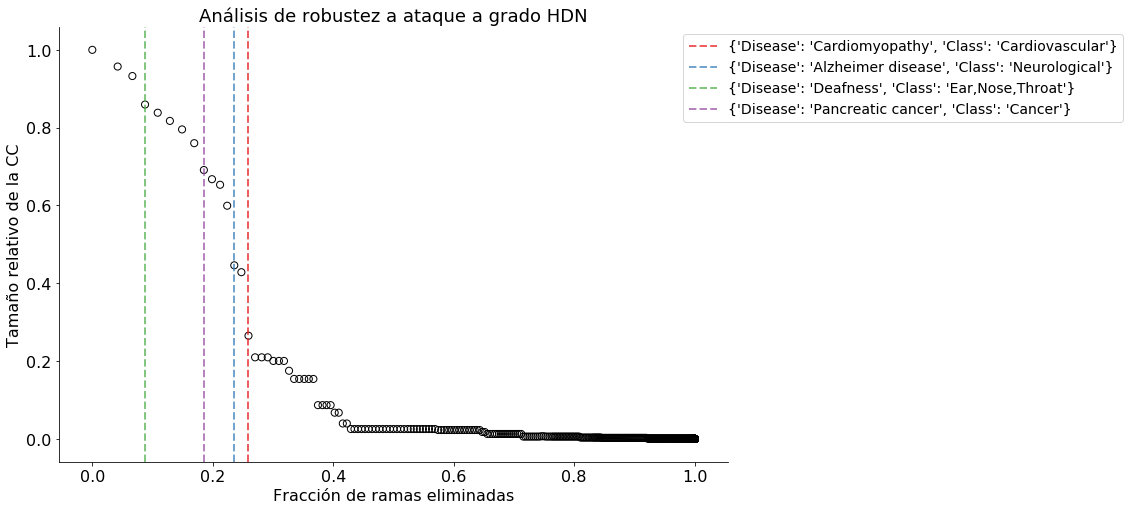

In [861]:
# HDN
x, y, eliminados, saltos =  attack_degree(hdn, eje_x = "frac_ramas")

plt.figure(figsize = (12, 8))
plt.scatter(x, y, marker = 'o', s = 50, facecolors='none', edgecolor = "black")

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

colors = plt.cm.Set1(np.linspace(0, 1, 10))
for i, color in zip(sorted(saltos, key = lambda k: k[2], reverse = True )[:4], colors):
    plt.axvline(i[0], c = color, label = i[1], alpha = 0.7, linestyle = "--", linewidth = 2)

plt.title("Análisis de robustez a ataque a grado HDN", fontsize = 18)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)

plt.xlabel("Fracción de ramas eliminadas", fontsize = 16)
plt.ylabel("Tamaño relativo de la CC", fontsize = 16)
    
plt.legend(bbox_to_anchor=(1.6, 1), fontsize = 14)
plt.savefig("./Imagenes/Ataques/HDN_ataque_grado.png", bbox_inches='tight')
plt.show()

Veo que cuando quito nodos con el criterio de mayor grado, desconecto mucho la componente gigante. Los saltos son número ramas que pieres. El eje Y está mirando como cambia el número de ramas. 

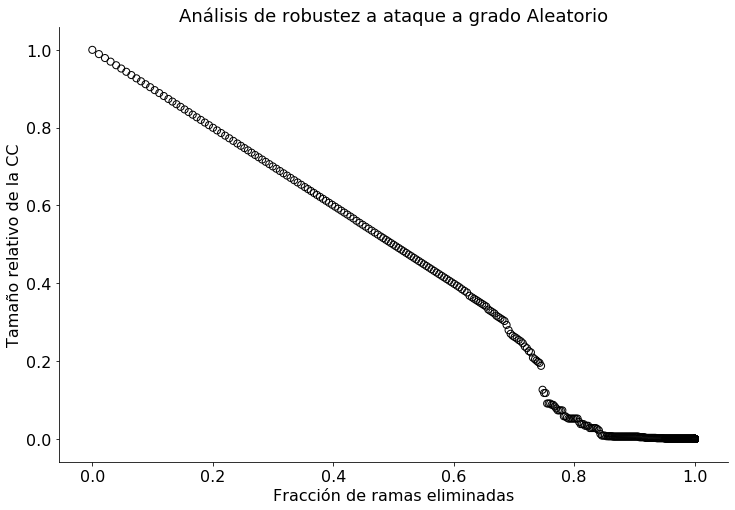

In [860]:
# Aleatoria
x, y, eliminados, saltos = attack_degree(G_AL, eje_x = "frac_ramas")

plt.figure(figsize = (12, 8))
plt.scatter(x, y, marker = 'o', s = 50, facecolors='none', edgecolor = "black")
# plt.plot(x, y)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)


plt.title("Análisis de robustez a ataque a grado Aleatorio", fontsize = 18)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)

plt.xlabel("Fracción de ramas eliminadas", fontsize = 16)
plt.ylabel("Tamaño relativo de la CC", fontsize = 16)
    
# plt.legend(bbox_to_anchor=(1.6, 1), fontsize = 14)
plt.savefig("./Imagenes/Ataques/AL_ataque_grado.png", bbox_inches='tight')
plt.show()

# Ataques en función del camino más corto

In [843]:
from random import choice
import copy
def attack_bt(Grafo, eje_x = "frac_nodos"):
    """
    Objetivo: Ataque aleatorio a redes eliminando progresivamente nodos
    
    Resumen: Se realizan tanta iteraciones como nodos-1 tenga el grafo. En cada iteración se selecciona
             y elimina un nodo y sus ramas de forma aleatoria del grafo inicial.
             
             La función almacena el número de nodos, ramas o la fracción de nodos o ramas eliminadas en cada iteración, al igual que el tamaño relativo
             de la componente conexa más grande tras eliminar el nodo.
             Finalmente, se almacena la variación del tamaño de la componente conexa en cada iteración. Estos
             resultados permiten al usuario visualizar qué nodos han provocado más daño en la red. 
             
             ADVERTENCIA: el daño a la red de cada nodo depende del nodo anterior. Es decir, el daño producido
             por un mismo nodo a la red, depende de los nodos eliminados anteriormente. 
             
             Se puede representar el tamaño de la componente conexa (CC) a medida que eliminamos nodos del grafo
    
    Argumentos:
        Grafo (network x graph): grafo de network x sobre el que realizar el ataque
        eje_x (string): Representar efecto del ataque en función del número de ramas eliminadas, 
                        número de nodos eliminados, fracción de ramas eliminadas o fracción de nodos eliminados
                        (default = "nodos")(Posibles valores: "frac_nodos", "frac_ramas", "nodos", "ramas")
                
        
    Return: 
        x (list): fracción de ramas / nodos eliminados
        y (list): tamaño relativo de la componente conexa más grande (normalizada por el tamaño inicial)
        nodos_eliminados (list): almacenamiento de la iteración, el nodo y la información del nodo eliminado
        saltos (list): lista de tuplas del valor del eje X, el nodo y la caída del tamaño de la componente conexa
                       en cada iteración. 
    """
    G = copy.deepcopy(Grafo)
    max_cc = nx.Graph(G.subgraph(max(nx.connected_components(G), key=len)))
    
    # Almacenamiento resultados
    x = [0] # Fracción de ramas eliminadas
    y = [1] # Tamaño relativo de la componente conexa más grande
    nodos_eliminados = []

    # Variables
    n = nx.number_of_nodes(G) # Numero de nodos iniciales
    r_inicial_grafo = nx.number_of_edges(G) # Numero de ramas iniciales X
    r_inicial_cc = nx.number_of_edges(max_cc) # Numero de ramas iniciales en la componente mas grande Y
   
    
    saltos = [] # almacenaré la magnitud de la caida del tamaño
    
    j = 1
    
    while j < n: # iteramos hasta quitar todos los nodos
        
        # Selección actualizada del nodo con mayor betweenness
        bt = nx.betweenness_centrality(G) 

        nodo = max(bt.items(), key = lambda k: k[1])[0] # de todo el grafo
        info = dict(list(G.nodes().items()))[max(bt.items(), key = lambda k: k[1])[0]]
        nodos_eliminados.append((j, nodo, info))
        
        # Eliminación del nodo y sus ramas incidentes de la componente conexa. 
        # Si no es posible eliminarla 
        G.remove_node(n = nodo)

        # Número de ramas en el grafo total tras la eliminación
        r_restantes_grafo = nx.number_of_edges(G)
        fra_el = (r_inicial_grafo - r_restantes_grafo) / r_inicial_grafo
        
        
        # Obtenemos la componente conexa más grande tras la eliminacion
        max_cc = nx.Graph(G.subgraph(max(nx.connected_components(G), key=len)))
        
        
        # Numero de ramas en la componente conexa tras la eliminacion
        r_cc = nx.number_of_edges(max_cc) 
    
        if eje_x == "nodos":
             x.append( j )
        
        if eje_x == "ramas":
            x.append( b-a )
        
        # Fracción de nodos eliminados
        if eje_x == "frac_nodos":
            x.append( j/n )
        
        # Fracción de ramas eliminadas
        if eje_x == "frac_ramas":
            x.append( fra_el )
        
        # Tamaño relativo de la componente conexa más grande
        y.append( r_cc / r_inicial_cc )

        
       
        
        # Anoto la magnitud de la caida (salto) del tamaño
        if j == 1:
            saltos.append( (x[j], Grafo.nodes[nodo], 1 - y[j]) ) # Guardo en una tupla la pos del eje x y la magnitud de la caída
        else:
            saltos.append( (x[j], Grafo.nodes[nodo], y[j-1] - y[j]) ) 

        j += 1
        
    return x, y, nodos_eliminados, saltos  

## Ataque en HDN

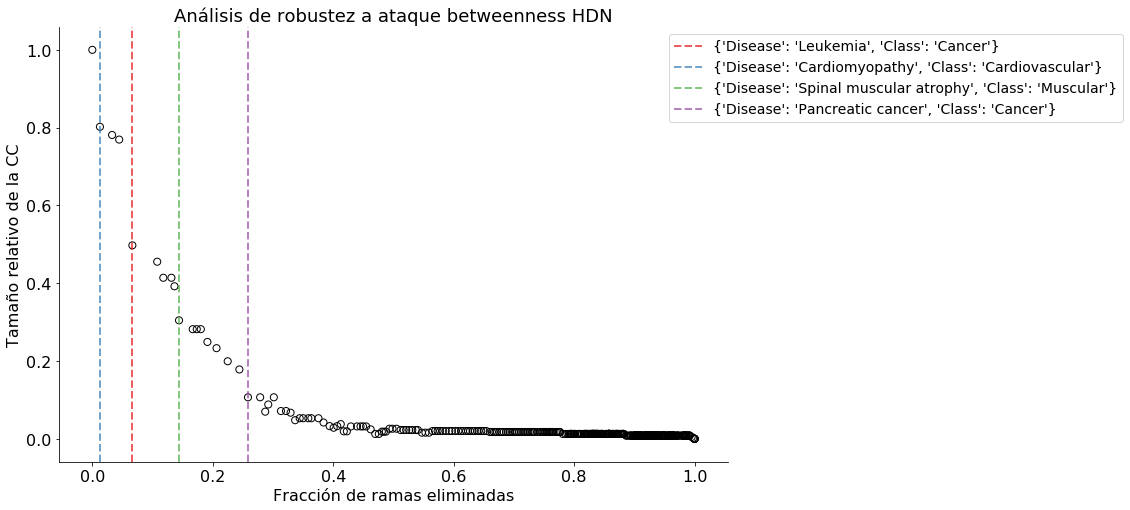

In [859]:
# HDN
x, y, eliminados, saltos =  attack_bt(hdn, eje_x = "frac_ramas")

plt.figure(figsize = (12, 8))
plt.scatter(x, y, marker = 'o', s = 50, facecolors='none', edgecolor = "black")

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

colors = plt.cm.Set1(np.linspace(0, 1, 10))
for i, color in zip(sorted(saltos, key = lambda k: k[2], reverse = True )[:4], colors):
    plt.axvline(i[0], c = color, label = i[1], alpha = 0.7, linestyle = "--", linewidth = 2)

plt.title("Análisis de robustez a ataque betweenness HDN", fontsize = 18)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)

plt.xlabel("Fracción de ramas eliminadas", fontsize = 16)
plt.ylabel("Tamaño relativo de la CC", fontsize = 16)
    
plt.legend(bbox_to_anchor=(1.6, 1), fontsize = 14)
plt.savefig("./Imagenes/Ataques/HDN_ataque_bt.png", bbox_inches='tight')
plt.show()

## Ataque en grafo aleatorio

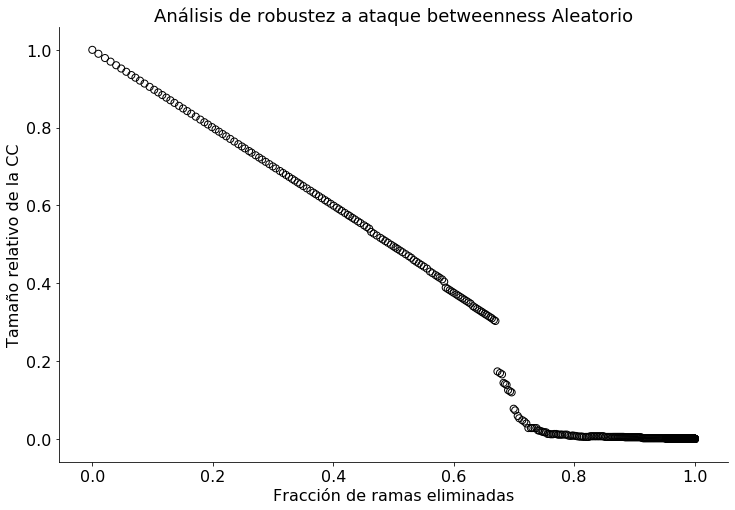

In [862]:
# HDN
x, y, eliminados, saltos =  attack_bt(G_AL, eje_x = "frac_ramas")

plt.figure(figsize = (12, 8))
plt.scatter(x, y, marker = 'o', s = 50, facecolors='none', edgecolor = "black")

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)


plt.title("Análisis de robustez a ataque betweenness Aleatorio", fontsize = 18)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)

plt.xlabel("Fracción de ramas eliminadas", fontsize = 16)
plt.ylabel("Tamaño relativo de la CC", fontsize = 16)
    
#plt.legend(bbox_to_anchor=(1.6, 1), fontsize = 14)
plt.savefig("./Imagenes/Ataques/AL_ataque_bt.png", bbox_inches='tight')
plt.show()

## Visualización conjunta

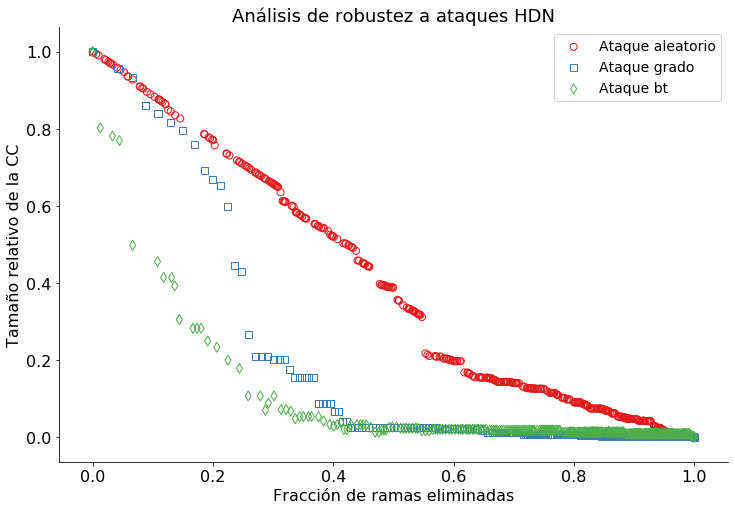

In [856]:
# HDN
plt.figure(figsize = (12, 8))
colors = plt.cm.Set1(np.linspace(0, 1, 10))

# Aleatorio
x_al, y_al, eliminados_al, saltos_al =  failure(hdn, eje_x = "frac_ramas")

plt.scatter(x_al, y_al, marker = 'o', s = 50, 
            facecolors='none', edgecolor = colors[0], label = "Ataque aleatorio")

# Grado
x_dg, y_dg, eliminados_dg, saltos_dg =  attack_degree(hdn, eje_x = "frac_ramas")
plt.scatter(x_dg, y_dg, marker = 's', s = 50, facecolors='none', edgecolor = colors[1], label = "Ataque grado")

# Bt
x_bt, y_bt, eliminados_bt, saltos_bt =  attack_bt(hdn, eje_x = "frac_ramas")
plt.scatter(x_bt, y_bt, marker = 'd', s = 50, facecolors='none', edgecolor = colors[2], label = "Ataque bt")


plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

colors = plt.cm.Set1(np.linspace(0, 1, 10))
#for i, color in zip(sorted(saltos, key = lambda k: k[2], reverse = True )[:4], colors):
 #   plt.axvline(i[0], c = color, label = i[1], alpha = 0.7, linestyle = "--", linewidth = 2)

plt.title("Análisis de robustez a ataques HDN", fontsize = 18)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)

plt.xlabel("Fracción de ramas eliminadas", fontsize = 16)
plt.ylabel("Tamaño relativo de la CC", fontsize = 16)
    
plt.legend(loc = "upper right", fontsize = 14)
plt.savefig("./Imagenes/Ataques/HDN_ataques.png", bbox_inches='tight')
plt.show()

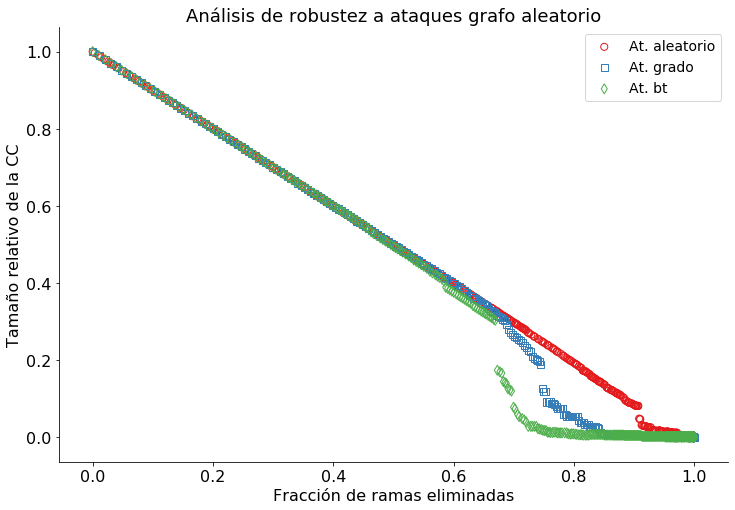

In [857]:
# aleatorio
plt.figure(figsize = (12, 8))
colors = plt.cm.Set1(np.linspace(0, 1, 10))

# Aleatorio
x_al, y_al, eliminados_al, saltos_al =  failure(G_AL, eje_x = "frac_ramas")

plt.scatter(x_al, y_al, marker = 'o', s = 50, 
            facecolors='none', edgecolor = colors[0], label = "At. aleatorio")

# Grado
x_dg, y_dg, eliminados_dg, saltos_dg =  attack_degree(G_AL, eje_x = "frac_ramas")
plt.scatter(x_dg, y_dg, marker = 's', s = 50, facecolors='none', edgecolor = colors[1], label = "At. grado")

# Bt
x_bt, y_bt, eliminados_bt, saltos_bt =  attack_bt(G_AL, eje_x = "frac_ramas")
plt.scatter(x_bt, y_bt, marker = 'd', s = 50, facecolors='none', edgecolor = colors[2], label = "At. bt")


plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

colors = plt.cm.Set1(np.linspace(0, 1, 10))
#for i, color in zip(sorted(saltos, key = lambda k: k[2], reverse = True )[:4], colors):
 #   plt.axvline(i[0], c = color, label = i[1], alpha = 0.7, linestyle = "--", linewidth = 2)

plt.title("Análisis de robustez a ataques grafo aleatorio", fontsize = 18)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)

plt.xlabel("Fracción de ramas eliminadas", fontsize = 16)
plt.ylabel("Tamaño relativo de la CC", fontsize = 16)
    
plt.legend(loc = "upper right", fontsize = 14)
plt.savefig("./Imagenes/Ataques/Aleatorio_ataques.png", bbox_inches='tight')
plt.show()

## Ataque en función de PageRank

In [867]:
from random import choice
import copy
def attack_page_rank(Grafo, eje_x = "frac_nodos"):
    """
    Objetivo: Ataque aleatorio a redes eliminando progresivamente nodos
    
    Resumen: Se realizan tanta iteraciones como nodos-1 tenga el grafo. En cada iteración se selecciona
             y elimina un nodo y sus ramas de forma aleatoria del grafo inicial.
             
             La función almacena el número de nodos, ramas o la fracción de nodos o ramas eliminadas en cada iteración, al igual que el tamaño relativo
             de la componente conexa más grande tras eliminar el nodo.
             Finalmente, se almacena la variación del tamaño de la componente conexa en cada iteración. Estos
             resultados permiten al usuario visualizar qué nodos han provocado más daño en la red. 
             
             ADVERTENCIA: el daño a la red de cada nodo depende del nodo anterior. Es decir, el daño producido
             por un mismo nodo a la red, depende de los nodos eliminados anteriormente. 
             
             Se puede representar el tamaño de la componente conexa (CC) a medida que eliminamos nodos del grafo
    
    Argumentos:
        Grafo (network x graph): grafo de network x sobre el que realizar el ataque
        eje_x (string): Representar efecto del ataque en función del número de ramas eliminadas, 
                        número de nodos eliminados, fracción de ramas eliminadas o fracción de nodos eliminados
                        (default = "nodos")(Posibles valores: "frac_nodos", "frac_ramas", "nodos", "ramas")
                
        
    Return: 
        x (list): fracción de ramas / nodos eliminados
        y (list): tamaño relativo de la componente conexa más grande (normalizada por el tamaño inicial)
        nodos_eliminados (list): almacenamiento de la iteración, el nodo y la información del nodo eliminado
        saltos (list): lista de tuplas del valor del eje X, el nodo y la caída del tamaño de la componente conexa
                       en cada iteración. 
    """
    G = copy.deepcopy(Grafo)
    max_cc = nx.Graph(G.subgraph(max(nx.connected_components(G), key=len)))
    
    # Almacenamiento resultados
    x = [0] # Fracción de ramas eliminadas
    y = [1] # Tamaño relativo de la componente conexa más grande
    nodos_eliminados = []

    # Variables
    n = nx.number_of_nodes(G) # Numero de nodos iniciales
    r_inicial_grafo = nx.number_of_edges(G) # Numero de ramas iniciales X
    r_inicial_cc = nx.number_of_edges(max_cc) # Numero de ramas iniciales en la componente mas grande Y
   
    
    saltos = [] # almacenaré la magnitud de la caida del tamaño
    
    j = 1
    
    while j < n: # iteramos hasta quitar todos los nodos
        
        # Selección actualizada del nodo con mayor betweenness
        pk = nx.pagerank(G) 

        nodo = max(pk.items(), key = lambda k: k[1])[0] # de todo el grafo
        info = dict(list(G.nodes().items()))[max(pk.items(), key = lambda k: k[1])[0]]
        nodos_eliminados.append((j, nodo, info))
        
        # Eliminación del nodo y sus ramas incidentes de la componente conexa. 
        # Si no es posible eliminarla 
        G.remove_node(n = nodo)

        # Número de ramas en el grafo total tras la eliminación
        r_restantes_grafo = nx.number_of_edges(G)
        fra_el = (r_inicial_grafo - r_restantes_grafo) / r_inicial_grafo
        
        
        # Obtenemos la componente conexa más grande tras la eliminacion
        max_cc = nx.Graph(G.subgraph(max(nx.connected_components(G), key=len)))
        
        
        # Numero de ramas en la componente conexa tras la eliminacion
        r_cc = nx.number_of_edges(max_cc) 
    
        if eje_x == "nodos":
             x.append( j )
        
        if eje_x == "ramas":
            x.append( b-a )
        
        # Fracción de nodos eliminados
        if eje_x == "frac_nodos":
            x.append( j/n )
        
        # Fracción de ramas eliminadas
        if eje_x == "frac_ramas":
            x.append( fra_el )
        
        # Tamaño relativo de la componente conexa más grande
        y.append( r_cc / r_inicial_cc )

        
       
        
        # Anoto la magnitud de la caida (salto) del tamaño
        if j == 1:
            saltos.append( (x[j], Grafo.nodes[nodo], 1 - y[j]) ) # Guardo en una tupla la pos del eje x y la magnitud de la caída
        else:
            saltos.append( (x[j], Grafo.nodes[nodo], y[j-1] - y[j]) ) 

        j += 1
        
    return x, y, nodos_eliminados, saltos  

## HDN

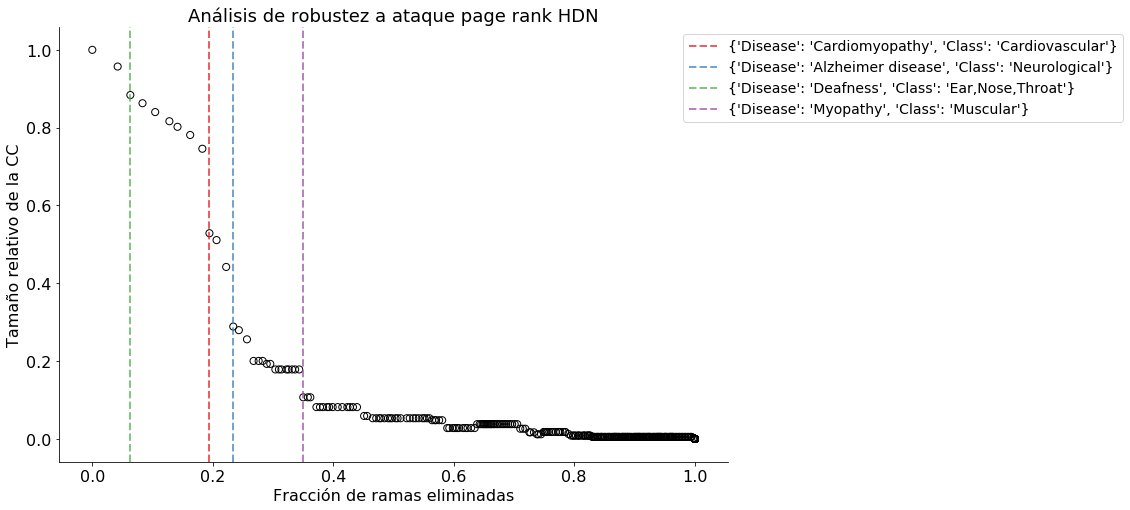

In [871]:
# HDN
x, y, eliminados, saltos =  attack_page_rank(hdn, eje_x = "frac_ramas")

plt.figure(figsize = (12, 8))
plt.scatter(x, y, marker = 'o', s = 50, facecolors='none', edgecolor = "black")

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

colors = plt.cm.Set1(np.linspace(0, 1, 10))
for i, color in zip(sorted(saltos, key = lambda k: k[2], reverse = True )[:4], colors):
    plt.axvline(i[0], c = color, label = i[1], alpha = 0.7, linestyle = "--", linewidth = 2)

plt.title("Análisis de robustez a ataque page rank HDN", fontsize = 18)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)

plt.xlabel("Fracción de ramas eliminadas", fontsize = 16)
plt.ylabel("Tamaño relativo de la CC", fontsize = 16)
    
plt.legend(bbox_to_anchor=(1.6, 1), fontsize = 14)
plt.savefig("./Imagenes/Ataques/HDN_ataque_pk.png", bbox_inches='tight')
plt.show()

### Aleatorio

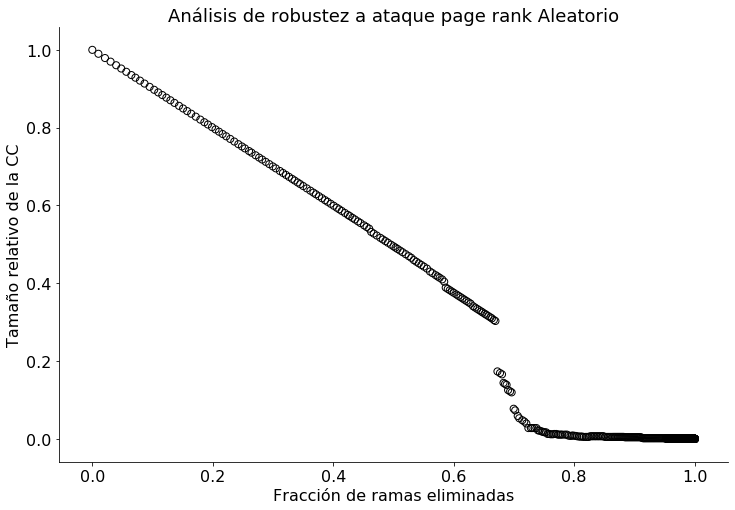

In [872]:
# HDN
x, y, eliminados, saltos =  attack_bt(G_AL, eje_x = "frac_ramas")

plt.figure(figsize = (12, 8))
plt.scatter(x, y, marker = 'o', s = 50, facecolors='none', edgecolor = "black")

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)


plt.title("Análisis de robustez a ataque page rank Aleatorio", fontsize = 18)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)

plt.xlabel("Fracción de ramas eliminadas", fontsize = 16)
plt.ylabel("Tamaño relativo de la CC", fontsize = 16)
    
# plt.legend(bbox_to_anchor=(1.6, 1), fontsize = 14)
plt.savefig("./Imagenes/Ataques/Aleatorio_ataque_pk.png", bbox_inches='tight')
plt.show()